# **CS109B Project: Module A**

Group 7: Karthikeyan Chandrasekaran, Maggie Lau, and Evan Wan 

---

# **1. Introduction**


**Problem Statement:**

Our objective is to build and assess a predictive model using chest x-ray images for 15 distinct labels indicating the presence or lack thereof of thoracic diseases. Given the cost-effectiveness of x-ray imaging, producing a model that has the ability to accurately diagnose thoracic diseases using x-ray images could significantly improve early diagnosis and administration of medical treatment before onset of pathogenesis.

Our target variable will be a multiclassification label that predicts a single class label for the image. If time permits, we will attempt multilabel classification and techniques used to alleviate the severe class imbalance that often plagues multilabel classification.


**Description:**

The data used in this project is ChestX-ray14, which is the updated version of ChestX-ray8 data set from Wang et al. 2017. The dataset is comprised of 112,120 frontal-view X-ray images of 30,805 unique patients. The disease labels for each image are derived using natural language processing to mine text from the
associated radiological reports from which the images are taken. There are 14 distinct disease labels and a “No Finding” label, and each image can have 1 or more labels. Additionally, the dataset labels can be expected to have an accuracy of approximately 90%, though there may be some disputes about the veracity of this claim, which will be discussed below.



In this introductory section, we prepare out notebook to work with our dataset by mounting our google colab drive, importing all necessary libraries, and changing our root directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pathlib
import time
import zipfile
import warnings
warnings.filterwarnings('ignore')

import urllib.request
import imageio
import tarfile
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Lambda
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, precision_score, recall_score
import tqdm
import cv2
import os
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, accuracy_score
from sklearn import metrics
import glob as glob
from __future__ import print_function, division
from builtins import range, input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

%matplotlib inline
SEED = 2266

In [ ]:
from prettytable import PrettyTable
import matplotlib
matplotlib.__version__



'3.5.2'

In [ ]:
os.chdir('/content/drive/Shareddrives/cs109b Project')

---

# **2. Initial EDA**

In the intial EDA section, we perform intial exploration of data in order to make foundational choices of how we will approach our data and analysis. They are discussed below.

We first inspect the data set by dividing into the images by disease label counts. Our goal is to determine if multi-label classification is viable with this dataset.

We can observe from Figures 1 and 2 (below) that the number of images on average per unique disease combination for multilabel classification is low. Specifically, for unique disease combinations with 2 or more labels, there are 785 unique combinations with 20,796 images, resulting in an average of 26 images per unique disease combination. Additionally, we can observe from Figure 1 that 81% of the images in the data set are single labeled. We have further calculated that approximately 96% of the patients in the data set have single labels as well.

Given the above, we have decided to do multiclass classification on single labeled images, thus we ignore images with multiple labels. The resulting dataset of single labeled images has 91,324 unique images and 29,564 unique patient IDs.

We can observe from Figure 3 (below) that this dataset exhibits severe class imbalance with 8 out of 14 disease labels at 1% or less of the data set. In the final milestone of this project, we will implement methods such as data augmentation, up sampling and down sampling, in order to alleviate this class imbalance.

Finally, we can observe from Figure 4 and 5 (below) that the new dataset exhibits approximately even gender balance and a normal distribution in age groups, which is generally representative of the type of patient that requires x-ray screening for disease detection. This will allow us to build a model that can generalize to population that is most afflicted by these disease labels.




Code below creates binary labels that will help determine number of unique disease combinations.


In [ ]:
df_xray_data = pd.read_csv("Data_Entry_2017_v2020.csv")
df_xray_data.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                        0.143  0.143  
2                        0.168  0.168  
3                        0.171  0.171  
4                        0.168  0.168

In [ ]:
# Create Unique Labels
unique_finding_labels = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
         'Effusion', 'Emphysema', 'Fibrosis', 'Hernia','Infiltration',
         'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

finding_labels = list(df_xray_data['Finding Labels'])
len(finding_labels)

112120

In [ ]:
# Write function to create binary labels
def label_func(finding_labels, label):
    L = []
    for i in finding_labels:
        if label in i:
            L.append(1)
        else:
            L.append(0)
    return L

In [ ]:
# Create binary labels for "No Finding"
L0 = label_func(finding_labels = finding_labels, label = unique_finding_labels[0])

# Check labeling is correct
np.asarray(L0).sum()

60361

In [ ]:
L1 = label_func(finding_labels = finding_labels, label = unique_finding_labels[1])
L2 = label_func(finding_labels = finding_labels, label = unique_finding_labels[2])
L3 = label_func(finding_labels = finding_labels, label = unique_finding_labels[3])
L4 = label_func(finding_labels = finding_labels, label = unique_finding_labels[4])
L5 = label_func(finding_labels = finding_labels, label = unique_finding_labels[5])
L6 = label_func(finding_labels = finding_labels, label = unique_finding_labels[6])
L7 = label_func(finding_labels = finding_labels, label = unique_finding_labels[7])
L8 = label_func(finding_labels = finding_labels, label = unique_finding_labels[8])
L9 = label_func(finding_labels = finding_labels, label = unique_finding_labels[9])
L10 = label_func(finding_labels = finding_labels, label = unique_finding_labels[10])
L11 = label_func(finding_labels = finding_labels, label = unique_finding_labels[11])
L12 = label_func(finding_labels = finding_labels, label = unique_finding_labels[12])
L13 = label_func(finding_labels = finding_labels, label = unique_finding_labels[13])
L14 = label_func(finding_labels = finding_labels, label = unique_finding_labels[14])

In [ ]:
# Create df_bin_labeled with binary labels 
df_bin_labeled = df_xray_data.copy()
df_bin_labeled['L0'] = L0
df_bin_labeled['L1'] = L1
df_bin_labeled['L2'] = L2
df_bin_labeled['L3'] = L3
df_bin_labeled['L4'] = L4
df_bin_labeled['L5'] = L5
df_bin_labeled['L6'] = L6
df_bin_labeled['L7'] = L7
df_bin_labeled['L8'] = L8
df_bin_labeled['L9'] = L9
df_bin_labeled['L10'] = L10
df_bin_labeled['L11'] = L11
df_bin_labeled['L12'] = L12
df_bin_labeled['L13'] = L13
df_bin_labeled['L14'] = L14

In [ ]:
df_bin_labeled.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x  ...  L5  L6  L7  L8  L9  L10  L11  L12  L13  \
0                        0.143  ...   0   0   0   0   0    0    0    0    0   
1                        0.143  ...   0   1   0   0   0    0    0    0    0   
2                        0.168  ...   1   0   0   0   0    0    0    0    0   
3                        0.171  ...   0   0   0   0   0    0    0    0    0   
4                        0.168  ...   0   0   0   1   0    0    0    0    0   

   L14  
0    0  
1    0  
2    0  
3    0  
4    0  

[5 rows x 26 columns]

In [ ]:
# Create list of labels to determine unique binary lists
list_of_labels = []
list_of_labels.append(L0)
list_of_labels.append(L1)
list_of_labels.append(L2)
list_of_labels.append(L3)
list_of_labels.append(L4)
list_of_labels.append(L5)
list_of_labels.append(L6)
list_of_labels.append(L7)
list_of_labels.append(L8)
list_of_labels.append(L9)
list_of_labels.append(L10)
list_of_labels.append(L11)
list_of_labels.append(L12)
list_of_labels.append(L13)
list_of_labels.append(L14)


In [ ]:
# Create binary label for each image
image_label_list = []
for k in range(len(list_of_labels[0])):
    unique_bin_label = []
    for i in list_of_labels:
        unique_bin_label.append(i[k])
    image_label_list.append(unique_bin_label)
len(image_label_list)

112120

The below code counts the number of unique disease combinations.


In [ ]:
def num_unique_labels(image_label_list, label_count):
    label_count=label_count
    label_count_list =[]
    for i in image_label_list:
        if np.asarray(i).sum() == label_count:
            label_count_list.append(i)
    #print("Number of images with %d disease label: "%(label_count), len(label_count_list))
    
    label_count_unique = []
    for i in label_count_list:
        if i not in label_count_unique:
            label_count_unique.append(i)
    #print("Number of unique label combinations with %d diseases: "%(label_count), len(label_count_unique),"\n")
    
    z = []
    z.append(label_count_list)
    z.append(label_count_unique)
    
    return z

In [ ]:
num_images_list = []
num_unique_comb_list = []
for i in range(1,16):
  n = num_unique_labels(image_label_list=image_label_list, label_count=i)
  num_images_list.append(len(n[0]))
  num_unique_comb_list.append(len(n[1]))
print(num_images_list)
print(num_unique_comb_list)

[91324, 14306, 4856, 1247, 301, 67, 16, 1, 2, 0, 0, 0, 0, 0, 0]
[15, 89, 238, 256, 144, 42, 14, 1, 2, 0, 0, 0, 0, 0, 0]


In [ ]:
ratio_list = np.divide(np.asarray(num_images_list),np.asarray(num_unique_comb_list))
ratio_list[np.isnan(ratio_list)]=0
ratio_list = list(np.round_(ratio_list,decimals=1))


In [ ]:
perc_list = np.divide(np.asarray(num_images_list),np.asarray(num_images_list).sum())
perc_list = list(np.round(perc_list,decimals=2))


## 2.1 - Figure 1: Plot of four graphs concerning images, unique combinations, and count of labels. 

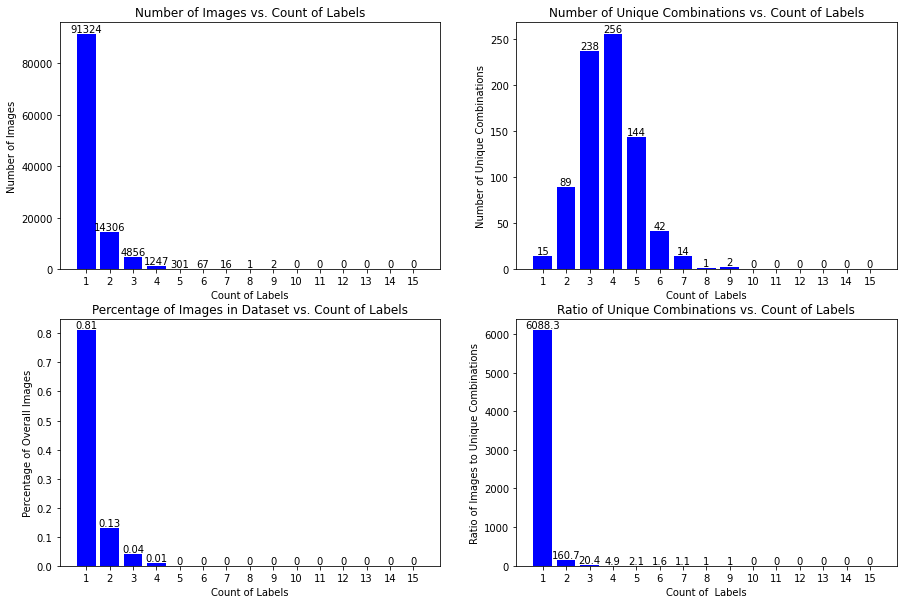

In [ ]:
# Plot bar graphs
fig, ax = plt.subplots(2,2, figsize=(15,10))

p1  = ax[0,0].bar(np.arange(1,16), num_images_list, color='blue', width=0.8)
p2  = ax[0,1].bar(np.arange(1,16), num_unique_comb_list, color='blue', width=0.8)
p3  = ax[1,0].bar(np.arange(1,16), perc_list, color='blue', width=0.8)
p4  = ax[1,1].bar(np.arange(1,16), ratio_list, color='blue', width=0.8)
ax[0,0].bar_label(p1)
ax[0,1].bar_label(p2)
ax[1,0].bar_label(p3)
ax[1,1].bar_label(p4)

# X-axis tick labels
ax[0,0].set_xticks(np.arange(1,16,1))
ax[0,1].set_xticks(np.arange(1,16,1))
ax[1,0].set_xticks(np.arange(1,16,1))
ax[1,1].set_xticks(np.arange(1,16,1))

# Axis labels
ax[0,0].set_xlabel("Count of Labels")
ax[0,1].set_xlabel("Count of  Labels")
ax[1,0].set_xlabel("Count of Labels")
ax[1,1].set_xlabel("Count of  Labels")

ax[0,0].set_ylabel("Number of Images")
ax[0,1].set_ylabel("Number of Unique Combinations")
ax[1,0].set_ylabel("Percentage of Overall Images")
ax[1,1].set_ylabel("Ratio of Images to Unique Combinations")

# Create titles
ax[0,0].title.set_text('Number of Images vs. Count of Labels')
ax[0,1].title.set_text('Number of Unique Combinations vs. Count of Labels')
ax[1,0].title.set_text('Percentage of Images in Dataset vs. Count of Labels')
ax[1,1].title.set_text('Ratio of Unique Combinations vs. Count of Labels')

In [ ]:
num_images_list.insert(0,"Number of Images")
num_unique_comb_list.insert(0,"Number of Unique Label Combinations")
ratio_list.insert(0,"Ratio of Images to Unique Label Combinations")

## 2.2 - Figure 2: Table showing number of images per count of labels.

In [ ]:
# create pretty table for unique disease combinations
mytable = PrettyTable()
mytable.field_names = ["Count of Labels",1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
mytable.add_row(num_images_list)
mytable.add_row(num_unique_comb_list)
mytable.add_row(ratio_list)
mytable.align['Count of Labels']='l'
print(mytable)

+----------------------------------------------+--------+-------+------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| Count of Labels                              |   1    |   2   |  3   |  4   |  5  |  6  |  7  |  8  |  9  |  10 |  11 |  12 |  13 |  14 |  15 |
+----------------------------------------------+--------+-------+------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| Number of Images                             | 91324  | 14306 | 4856 | 1247 | 301 |  67 |  16 |  1  |  2  |  0  |  0  |  0  |  0  |  0  |  0  |
| Number of Unique Label Combinations          |   15   |   89  | 238  | 256  | 144 |  42 |  14 |  1  |  2  |  0  |  0  |  0  |  0  |  0  |  0  |
| Ratio of Images to Unique Label Combinations | 6088.3 | 160.7 | 20.4 | 4.9  | 2.1 | 1.6 | 1.1 | 1.0 | 1.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
+----------------------------------------------+--------+-------+------+------+-----+-----+-----+-----+-----+-----+-----+---

In [ ]:
# Filtering df for only single label images
cols = ['L0','L1','L2','L3','L4','L5','L6','L7','L8','L9','L10','L11','L12','L13','L14']
df_labels = df_bin_labeled[cols]
rows = df_labels[df_labels.sum(axis=1) == 1].index
filtered_df = df_bin_labeled.iloc[rows]
filtered_df.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00000001_000.png   Cardiomegaly            0           1           57   
3  00000002_000.png     No Finding            0           2           80   
4  00000003_001.png         Hernia            0           3           74   
5  00000003_002.png         Hernia            1           3           75   
7  00000003_004.png         Hernia            3           3           77   

  Patient Gender View Position  OriginalImage[Width  Height]  \
0              M            PA                 2682     2749   
3              M            PA                 2500     2048   
4              F            PA                 2500     2048   
5              F            PA                 2048     2500   
7              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x  ...  L5  L6  L7  L8  L9  L10  L11  L12  L13  \
0                        0.143  ...   0   0   0   0   0    0    0    0    0   
3                        0.171  ...   0   0   0   0   0    0    0    0    0   
4                        0.168  ...   0   0   0   1   0    0    0    0    0   
5                        0.168  ...   0   0   0   1   0    0    0    0    0   
7                        0.168  ...   0   0   0   1   0    0    0    0    0   

   L14  
0    0  
3    0  
4    0  
5    0  
7    0  

[5 rows x 26 columns]

In [ ]:
labels, counts2 = np.unique(filtered_df['Patient ID'], return_counts = True)
len(labels)

29564

In [ ]:
# Plotting Number of Images Per Label
labels, counts2 = np.unique(filtered_df['Finding Labels'], return_counts = True)
disease_dict = dict(zip(counts2, labels))

# create list of diseases
sorted_nums_list = sorted(disease_dict, reverse=True)
sorted_disease_list = []
for i in sorted_nums_list:
    sorted_disease_list.append(disease_dict[i])

# create list of disease percentages
disease_perc  = np.divide(np.asarray(sorted_nums_list),np.asarray(sorted_nums_list).sum())

## 2.3 - Figure 3: Number of Images for each distinct label

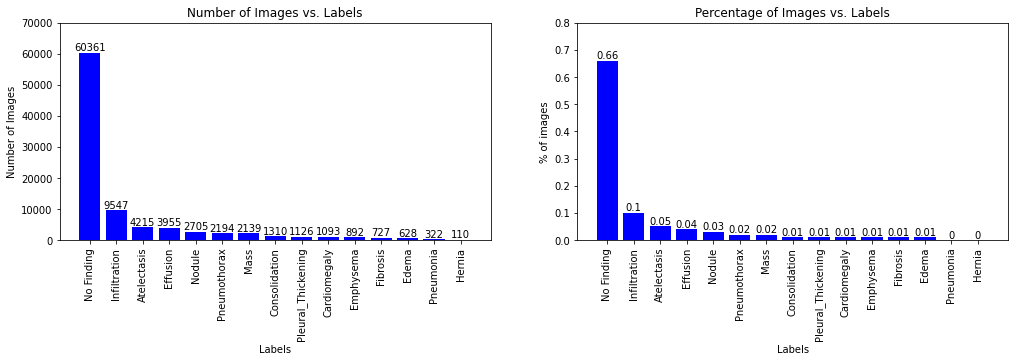

In [ ]:
# Plot side-by-side graph of silhouette scores and number of clusters with regards to t
fig, ax = plt.subplots(1,2, figsize=(17,4))

# Plot accuracy scores
p1  = ax[0].bar(np.arange(len(sorted_nums_list)),sorted_nums_list,color='blue', width=0.8)
p2  = ax[1].bar(np.arange(len(sorted_nums_list)),np.round(disease_perc,2),color='blue', width=0.8)
ax[0].bar_label(p1)
ax[1].bar_label(p2)
#ax[0].bar(sorted_disease_list,sorted_nums_list, label='Number of Images')
#ax[1].bar(sorted_disease_list,disease_perc, label='Number of Unique Combinattions')

# X-axis tick labels
ax[0].set_xticks(np.arange(len(sorted_disease_list)))
ax[1].set_xticks(np.arange(len(sorted_disease_list)))
ax[0].set_xticklabels(sorted_disease_list,rotation=90)
ax[1].set_xticklabels(sorted_disease_list,rotation=90)

ax[0].set_ylim(0,70000)
ax[1].set_ylim(0,0.8)

# Axis labels
ax[0].set_xlabel("Labels")
ax[1].set_xlabel("Labels")
ax[0].set_ylabel("Number of Images")
ax[1].set_ylabel("% of images")

# Create titles
ax[0].title.set_text('Number of Images vs. Labels')
ax[1].title.set_text('Percentage of Images vs. Labels')


## 2.4 - Figure 4: Gender Ratio of dataset


In [ ]:
labels, counts2 = np.unique(filtered_df['Patient Gender'], return_counts = True)
label_dict = dict(zip(counts2, labels))

# create list of diseases
sorted_nums_list = sorted(label_dict, reverse=True)
sorted_label_list = []
for i in sorted_nums_list:
    sorted_label_list.append(label_dict[i])

# create list of disease percentages
label_perc  = np.divide(np.asarray(sorted_nums_list),np.asarray(sorted_nums_list).sum())

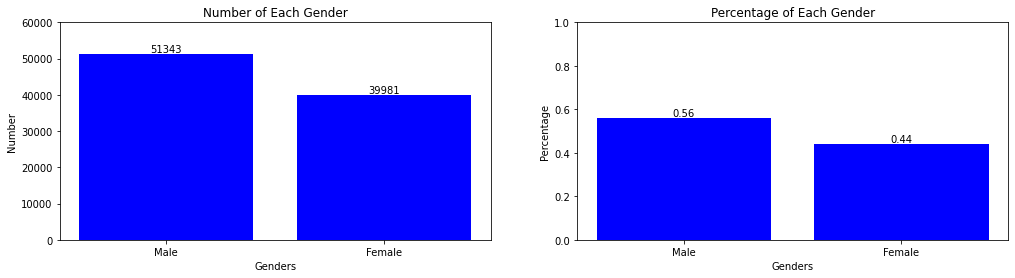

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(17,4))

# Plot graph
p1  = ax[0].bar(np.arange(len(sorted_nums_list)),sorted_nums_list,color='blue', width=0.8)
p2  = ax[1].bar(np.arange(len(sorted_nums_list)),np.round(label_perc,2),color='blue', width=0.8)
ax[0].bar_label(p1)
ax[1].bar_label(p2)
#ax[0].bar(sorted_disease_list,sorted_nums_list, label='Number of Images')
#ax[1].bar(sorted_disease_list,disease_perc, label='Number of Unique Combinattions')

# X-axis tick labels
ax[0].set_xticks(np.arange(len(sorted_label_list)))
ax[1].set_xticks(np.arange(len(sorted_label_list)))
ax[0].set_xticklabels(['Male','Female'])
ax[1].set_xticklabels(['Male','Female'])

ax[0].set_ylim(0,60000)
ax[1].set_ylim(0,1)

# Axis labels
ax[0].set_xlabel("Genders")
ax[1].set_xlabel("Genders")
ax[0].set_ylabel("Number")
ax[1].set_ylabel("Percentage")

# Create titles
ax[0].title.set_text('Number of Each Gender')
ax[1].title.set_text('Percentage of Each Gender')


## 2.5 - Figure 5: Histogram of Age Groups

Text(0.5, 1.0, 'Histogram of Age Groups')

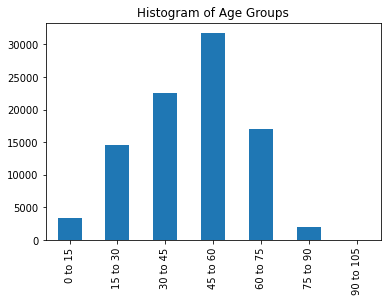

In [ ]:
pd.cut(filtered_df['Patient Age'], 
       bins=[0, 15, 30, 45, 60, 75, 90, 105], 
       labels = ['0 to 15','15 to 30',
                 '30 to 45','45 to 60',
                 '60 to 75', '75 to 90', '90 to 105']).value_counts(sort=False).plot.bar()
plt.title("Histogram of Age Groups")

---

# **3. Data Splitting and Avoiding Cross Validation Leakage**

In this section, we split the data into training, validation, and test sets. However, because of the nature of the data, there is possibility of cross-validation leakage across sets.

From inspection of the data, we see that a unique patient can have several x-rays images associated with it in the dataset. Because of this, when we split the data into training and test sets there is a possibility that a patient's x-ray images can be split into both the train and test set. This will cause a leaky cross validation and negatively impact our models performance. 

To alleviate this, we take necessary precautions to make sure the the train,validation, and test sets don't have overlapping Patient IDs. The steps are as follows:

<ol>
    <li>Split data into train and test sets with stratification on Finding Labels.</li>
    <li>Find Patient IDs that overlaps in the train and test set.</li>
    <li>Divide the overlapping Patient IDs into two sets and remove each set from the train or test set.</li>
    <li>Use these new Patient IDs to create new train and test sets that will not have overlapping Patient IDs.</li>
    <li>Double check that the stratification of Finding Labels was maintained in the new train and test sets.</li>
    <li>Repeat steps 1-5 to create the train and validation sets.</li>
</ol>


In [ ]:
df = df_xray_data.copy()

In [ ]:
# create df that has just observations where there are 0 ("No Finding") or 1 disease found
disease_ct_01 = df[df["Finding Labels"].isin(unique_finding_labels)]
disease_ct_01.head(10)

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0   00000001_000.png   Cardiomegaly            0           1           57   
3   00000002_000.png     No Finding            0           2           80   
4   00000003_001.png         Hernia            0           3           74   
5   00000003_002.png         Hernia            1           3           75   
7   00000003_004.png         Hernia            3           3           77   
8   00000003_005.png         Hernia            4           3           78   
9   00000003_006.png         Hernia            5           3           79   
10  00000003_007.png         Hernia            6           3           80   
11  00000003_000.png         Hernia            7           3           81   
13  00000005_000.png     No Finding            0           5           69   

   Patient Gender View Position  OriginalImage[Width  Height]  \
0               M            PA                 2682     2749   
3               M            PA                 2500     2048   
4               F            PA                 2500     2048   
5               F            PA                 2048     2500   
7               F            PA                 2500     2048   
8               F            PA                 2686     2991   
9               F            PA                 2992     2991   
10              F            PA                 2582     2905   
11              F            PA                 2582     2991   
13              F            PA                 2048     2500   

    OriginalImagePixelSpacing[x     y]  
0                         0.143  0.143  
3                         0.171  0.171  
4                         0.168  0.168  
5                         0.168  0.168  
7                         0.168  0.168  
8                         0.143  0.143  
9                         0.143  0.143  
10                        0.143  0.143  
11                        0.143  0.143  
13                        0.168  0.168

In [ ]:
total_patients = len(np.unique(df['Patient ID']))
disease_01_patients = len(np.unique(disease_ct_01['Patient ID']))

In the whole dataset, there are 30805 unique patients.
Of these patients, 29564 were diagnosed with none or 1 disease.
That accounts for 95.9714% of all of the patients.


**Step 1: Split data into train and test sets with stratification on Finding Labels**

In [ ]:
#split train and test set, stratify on Finding Labels
df_train, df_test = train_test_split(disease_ct_01, test_size = 0.2, random_state = SEED, stratify=disease_ct_01["Finding Labels"])

In [ ]:
df_train.shape

(73059, 11)

In [ ]:
df_test.shape

(18265, 11)

**Step 2: Find Patient IDs that overlaps in the train and test set**

In [ ]:
patient_train = set(df_train["Patient ID"].values) #unique patient IDs in train
patient_test  = set(df_test["Patient ID"].values) #unique patient IDs in test
print(f'There are {len(patient_train)} unique patients in the training set.')
print(f'There are {len(patient_test)} unique patients in the test set.')
overlap_patient = patient_train.intersection(patient_test) #overlapping patient IDs in train and test
print(f'There are {len(overlap_patient)} patients that are in both the training and test set.')

There are 25996 unique patients in the training set.
There are 10692 unique patients in the test set.
There are 7124 patients that are in both the training and test set.


**Step 3: Divide the overlapping Patient IDs into two sets and remove each set from the train or test set**

In [ ]:
#split the overlaps 50/50 to remove from the train and test sets
overlap_train, overlap_test = train_test_split(list(overlap_patient), test_size = 0.5, random_state = SEED)

In [ ]:
overlap_test.sort()
len(overlap_test)

3562

In [ ]:
overlap_train.sort()
len(overlap_train)

3562

In [ ]:
#remove overlapping IDs
train_ids = [x for x in patient_train if x not in overlap_test]
test_ids = [x for x in patient_test if x not in overlap_train]

In [ ]:
#sanity check - see if patient IDs in train and test sum to total unique patient IDs
disease_01_patients == len(train_ids) + len(test_ids)

True

In [ ]:
#sanity check - see if there are any patient ID overlaps
for x in train_ids:
    if x in test_ids:
        print('Uh Oh')

**Step 4: Use these new Patient IDs to create new train and test sets that will not have overlapping Patient IDs**

In [ ]:
#create train df with unique patient IDs
df_train_unique = disease_ct_01[disease_ct_01["Patient ID"].isin(train_ids)]
df_train_unique.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
3  00000002_000.png     No Finding            0           2           80   
4  00000003_001.png         Hernia            0           3           74   
5  00000003_002.png         Hernia            1           3           75   
7  00000003_004.png         Hernia            3           3           77   
8  00000003_005.png         Hernia            4           3           78   

  Patient Gender View Position  OriginalImage[Width  Height]  \
3              M            PA                 2500     2048   
4              F            PA                 2500     2048   
5              F            PA                 2048     2500   
7              F            PA                 2500     2048   
8              F            PA                 2686     2991   

   OriginalImagePixelSpacing[x     y]  
3                        0.171  0.171  
4                        0.168  0.168  
5                        0.168  0.168  
7                        0.168  0.168  
8                        0.143  0.143

In [ ]:
#create test df with unique patient IDs
df_test_unique = disease_ct_01[disease_ct_01["Patient ID"].isin(test_ids)]
df_test_unique.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0   00000001_000.png   Cardiomegaly            0           1           57   
13  00000005_000.png     No Finding            0           5           69   
14  00000005_001.png     No Finding            1           5           69   
15  00000005_002.png     No Finding            2           5           69   
16  00000005_003.png     No Finding            3           5           69   

   Patient Gender View Position  OriginalImage[Width  Height]  \
0               M            PA                 2682     2749   
13              F            PA                 2048     2500   
14              F            AP                 2500     2048   
15              F            AP                 2500     2048   
16              F            PA                 2992     2991   

    OriginalImagePixelSpacing[x     y]  
0                         0.143  0.143  
13                        0.168  0.168  
14                        0.168  0.168  
15                        0.168  0.168  
16                        0.143  0.143

In [ ]:
len(df_test_unique)

32595

In [ ]:
#sanity check
disease_ct_01.shape[0] == df_train_unique.shape[0] + df_test_unique.shape[0]

True

**Step 5: Double check that the stratification of Finding Labels was maintained in the new train and test sets**

We need to check to see if the proportion of each disease is still comparable in the train and test set (we statified on the disease label when splitting train/test initially) after removing the duplicate patients from each set. Having a similar portion of each disease in both datasets will help ensure that the model does not become bias towards one disease.

In [ ]:
#get name of disease and their counts from the train and test sets
disease_names_train, disease_counts_train = np.unique(df_train_unique['Finding Labels'],return_counts = True)
disease_names_test, disease_counts_test = np.unique(df_test_unique['Finding Labels'],return_counts = True)

We can observe from the below two cells and their outputs that  comparing the breakdown of disease labels in both the train and test sets show that the proportions are still quite similar even after removing the overlapping patient IDs.

In [ ]:
#show count of disease in train set as a % of the total
disease_counts_train_total = sum(disease_counts_train)
for i in range(len(disease_names_train)):
    print(disease_names_train[i], ": ", f'{100*(disease_counts_train[i]/disease_counts_train_total):.4f}%')

Atelectasis :  4.4492%
Cardiomegaly :  1.1953%
Consolidation :  1.2549%
Edema :  0.5789%
Effusion :  4.0815%
Emphysema :  0.9484%
Fibrosis :  0.7969%
Hernia :  0.1294%
Infiltration :  9.9848%
Mass :  2.3379%
No Finding :  67.4573%
Nodule :  3.0513%
Pleural_Thickening :  1.2396%
Pneumonia :  0.3474%
Pneumothorax :  2.1472%


In [ ]:
#show count of disease in test set as a % of the total
disease_counts_test_total = sum(disease_counts_test)
for i in range(len(disease_names_test)):
    print(disease_names_test[i], ": ", f'{100*(disease_counts_test[i]/disease_counts_test_total):.4f}%')

Atelectasis :  4.9149%
Cardiomegaly :  1.1996%
Consolidation :  1.7579%
Edema :  0.8836%
Effusion :  4.7799%
Emphysema :  1.0278%
Fibrosis :  0.7946%
Hernia :  0.1043%
Infiltration :  11.2993%
Mass :  2.3501%
No Finding :  63.6417%
Nodule :  2.8010%
Pleural_Thickening :  1.2210%
Pneumonia :  0.3620%
Pneumothorax :  2.8624%


**Step 6: Repeat steps 1-5 to create the train and validation sets**

In [ ]:
#split train and validation set, stratify on Finding Labels
df_train_final, df_val = train_test_split(df_train_unique, test_size = 0.2, random_state = SEED, stratify=df_train_unique["Finding Labels"])

In [ ]:
patient_train_final = set(df_train_final["Patient ID"].values) #unique patient IDs in train
patient_val  = set(df_val["Patient ID"].values) #unique patient IDs in test
print(f'There are {len(patient_train_final)} unique patients in the training set.')
print(f'There are {len(patient_val)} unique patients in the validation set.')
overlap_patient_trainval = patient_train_final.intersection(patient_val) #overlapping patient IDs in train and test
print(f'There are {len(overlap_patient_trainval)} patients that are in both the training and validation set.')

There are 19537 unique patients in the training set.
There are 7622 unique patients in the validation set.
There are 4725 patients that are in both the training and validation set.


In [ ]:
#split the overlaps 30/70 to remove from the train and val sets
overlap_train_final, overlap_val = train_test_split(list(overlap_patient_trainval), test_size = 0.3, random_state = SEED)

In [ ]:
#remove overlapping IDs
train_final_ids = [x for x in patient_train_final if x not in overlap_val]
val_ids = [x for x in patient_val if x not in overlap_train_final]

In [ ]:
#sanity check
len(train_ids) == len(train_final_ids) + len(val_ids)

True

In [ ]:
#sanity check
for x in train_final_ids:
    if x in val_ids:
        print('Uh Oh')

In [ ]:
#create train df with unique patient IDs
df_train_final_unique = df_train_unique[df_train_unique["Patient ID"].isin(train_final_ids)]
df_train_final_unique.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
3  00000002_000.png     No Finding            0           2           80   
4  00000003_001.png         Hernia            0           3           74   
5  00000003_002.png         Hernia            1           3           75   
7  00000003_004.png         Hernia            3           3           77   
8  00000003_005.png         Hernia            4           3           78   

  Patient Gender View Position  OriginalImage[Width  Height]  \
3              M            PA                 2500     2048   
4              F            PA                 2500     2048   
5              F            PA                 2048     2500   
7              F            PA                 2500     2048   
8              F            PA                 2686     2991   

   OriginalImagePixelSpacing[x     y]  
3                        0.171  0.171  
4                        0.168  0.168  
5                        0.168  0.168  
7                        0.168  0.168  
8                        0.143  0.143

In [ ]:
df_val_unique = df_train_unique[df_train_unique["Patient ID"].isin(val_ids)]
df_val_unique.head()

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
21  00000006_000.png     No Finding            0           6           81   
28  00000011_000.png       Effusion            0          11           74   
29  00000011_001.png     No Finding            1          11           74   
30  00000011_002.png     No Finding            2          11           75   
31  00000011_003.png     No Finding            3          11           75   

   Patient Gender View Position  OriginalImage[Width  Height]  \
21              M            PA                 2500     2048   
28              M            PA                 2638     2449   
29              M            PA                 2500     2048   
30              M            PA                 2714     2781   
31              M            PA                 2500     2048   

    OriginalImagePixelSpacing[x     y]  
21                        0.168  0.168  
28                        0.143  0.143  
29                        0.168  0.168  
30                        0.143  0.143  
31                        0.168  0.168

In [ ]:
df_val_unique.dtypes

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
dtype: object

In [ ]:
len(df_train_final_unique)

45780

In [ ]:
len(df_val_unique)

12949

In [ ]:
#get name of disease and their counts from the train and test sets
disease_names_train_final, disease_counts_train_final = np.unique(df_train_final_unique['Finding Labels'],return_counts = True)
disease_names_val, disease_counts_val = np.unique(df_val_unique['Finding Labels'],return_counts = True)

We again can observe from the below two cells and their outupts that comparing the breakdown of disease labels in both the train and validation sets show that the proportions are still quite similar even after removing the overlapping patient IDs.


In [ ]:
#show count of disease in train set as a % of the total
disease_counts_train_final_total = sum(disease_counts_train_final)
for i in range(len(disease_names_train_final)):
    print(disease_names_train_final[i], ": ", f'{100*(disease_counts_train_final[i]/disease_counts_train_final_total):.4f}%')

Atelectasis :  4.3447%
Cardiomegaly :  1.2232%
Consolidation :  1.2014%
Edema :  0.5002%
Effusion :  3.9406%
Emphysema :  0.9742%
Fibrosis :  0.7798%
Hernia :  0.1332%
Infiltration :  9.8820%
Mass :  2.4552%
No Finding :  67.6540%
Nodule :  3.0668%
Pleural_Thickening :  1.2779%
Pneumonia :  0.3473%
Pneumothorax :  2.2193%


In [ ]:
#show count of disease in train set as a % of the total
disease_counts_val_total = sum(disease_counts_val)
for i in range(len(disease_names_val)):
    print(disease_names_val[i], ": ", f'{100*(disease_counts_val[i]/disease_counts_val_total):.4f}%')

Atelectasis :  4.8189%
Cardiomegaly :  1.0966%
Consolidation :  1.4441%
Edema :  0.8572%
Effusion :  4.5795%
Emphysema :  0.8572%
Fibrosis :  0.8572%
Hernia :  0.1158%
Infiltration :  10.3483%
Mass :  1.9229%
No Finding :  66.7619%
Nodule :  2.9964%
Pleural_Thickening :  1.1043%
Pneumonia :  0.3475%
Pneumothorax :  1.8920%


---

# **4. Creating TF Dataset and Preprocessing Images**

Before creating the train, test and validation tensorflow datasets that we will feed into our models, we first have to pre-process the images. As part of pre-processing, we resized the images to be 150x150x3. Initially we tried a larger image size because it would give the model more data to learn, but we were limited by computational resources.

Additionally, we augmented the images so the model would be less prone to overfitting. Image data augmentation was used to improve model performance and reduce generalization error and test-time augmentation was used to improve the predictive performance of model. The augmentation we implemented were randomly flipping the image horizontally, randomly flipping the image vertically, randomly adjusting the saturation of the image to a value between the range of 0.8 and 1.2, randomly adjusting the brightness of the image to +/- 0.1, and randomly adjusting the contrast of the image to a value between the range of 0.8 and 1.2.

In order to help train the model more efficiently, we decided to use tensorflow datasets to feed into our model. This will allow us to fetch and pre-process the next batch of images while the model is training on the current batch. Not only is this more time efficient, this also allows us to take full advantage of our computational resources.


The purpose of the code below is to download the dataset from the original zip file, and unzip them into our directory. The code is commented out to prevent re-running.

In [ ]:
#!/usr/bin/env python3
# Download the 56 zip files in Images_png in batches
# # URLs for the zip files
#links = [
     #'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
     #'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
     #'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
     #'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
     #'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
     #'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
     #'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
     #'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
     #'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
     #'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
     #'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
     #'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
 #]

#for idx, link in enumerate(links):
    #fn = 'images_%02d.tar.gz' % (idx+1)
    #print('downloading'+fn+'...')
    #urllib.request.urlretrieve(link, fn)  # download the zip file

#print("Download complete. Please check the checksums")

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# open file
# for i in range(10,13):
#     file = tarfile.open('images_'+str(i)+'.tar.gz')
#     # extracting file
#     file.extractall('/content/drive/Shared drives/cs109b Project'+str(i))
#     file.close()

In [ ]:
# get train, val, and test file name for images
train_filenames = df_train_final_unique['Image Index'].values
val_filenames = df_val_unique['Image Index'].values
test_filenames = df_test_unique['Image Index'].values

glob.glob('/data/' + "*/*/" + test_filenames[0])

In [ ]:
# # get file path with file name
# train_paths = []
# for i in range(len(train_filenames)):
#     if i % 5000 == 0:
#         print(i)
#     path = glob.glob('data/' + "*/*/" + train_filenames[i])
#     train_paths.append(path)
    
# #unnest file path 
# train_paths_str = []
# for i in range(len(train_paths)):
#     if i % 5000 == 0:
#         print(i)
#     train_paths_str.append(train_paths[i][0])

In [ ]:
# # pickle train file paths
# with open("train_paths_o", "wb") as train_paths:   #Pickling
#   pickle.dump(train_paths_str, train_paths)
# with open("train_paths_o", "rb") as train_paths:   # Unpickling
#   train_paths_str = pickle.load(train_paths)

In [ ]:
# get file path with file name
val_paths = []
for i in range(len(val_filenames)):
    path = glob.glob('data/' + "*/*/" + val_filenames[i])
    val_paths.append(path)

#unnest file path 
val_path_str = []
for i in range(len(val_paths)):
    val_path_str.append(val_paths[i][0])

In [ ]:
# pickle validation file paths
# with open("val_paths_o", "wb") as val_paths:   #Pickling
#   pickle.dump(train_paths_str, val_paths)
# with open("val_paths_o", "rb") as val_paths:   # Unpickling
#   val_paths_str = pickle.load(val_paths)

In [ ]:
# get file path with file name
test_paths = []
for i in range(len(test_filenames)):
    path = glob.glob('data/' + "*/*/" + test_filenames[i])
    test_paths.append(path)

#unnest file path 
test_paths_str = []
for i in range(len(test_paths)):
    test_paths_str.append(test_paths[i][0])

In [ ]:
## pickle test file paths
# with open("test_paths_o", "wb") as test_paths:   #Pickling
#   pickle.dump(test_paths_str, test_paths)
# with open("test_paths_o", "rb") as test_paths:   # Unpickling
#   test_paths_str = pickle.load(test_paths)

The purpose of the code below is to create functions for creating TensorFlow Datasets

In [ ]:
BATCH_SIZE = 1
IMG_SIZE = 150

# Function to read the file, will use later in get_dataset function
def read_file(item):
    item['image'] = tf.io.read_file(item['path'])
    return item

# Function to preprocess file, including resizing and augmentation
# will use later in get_dataset function
def preprocess_image(item):
    #decode image as RGB (channels = 3)
    decoded = tf.image.decode_png(item['image'], channels=3)
    item['image'] = tf.image.resize(decoded, [IMG_SIZE, IMG_SIZE]) #resize image
    #data augmentation
    item['image'] = tf.image.random_flip_left_right(item['image'])
    item['image'] = tf.image.random_flip_up_down(item['image'])
    item['image'] = tf.image.random_saturation(item['image'], 0.8, 1.2)
    item['image'] = tf.image.random_brightness(item['image'], 0.1)
    item['image'] = tf.image.random_contrast(item['image'], 0.8, 1.2)
    return item

def get_dataset(dataframe, paths, shuffled=True, augmented=False):
    #set autotune
    auto = tf.data.experimental.AUTOTUNE
    
    #create new df with just relevant columns
    data = dataframe[['Image Index', 'Finding Labels']].copy()
    data.columns = ['image', 'label']
    data.image = paths
    
    #one hot encode labels
    encoded_labels = data.label.str.get_dummies().astype(int)
    
    #create dataset object
    dataset = tf.data.Dataset.from_tensor_slices({
    'index': data.index,
    'path': paths,
    'label': encoded_labels.values.astype(int)
})
    seed = 109
    if shuffled:
        dataset = dataset.shuffle(len(dataframe), seed=SEED)
    #call function to preprocess data
    dataset = dataset.map(lambda item: preprocess_image(read_file(item)), num_parallel_calls=auto)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(auto)
    
    return dataset

In [ ]:
### Create TF datasets for training, validation and testing
train_TFdataset = get_dataset(df_train_final_unique, train_paths_str, shuffled=True)
val_TFdataset = get_dataset(df_val_unique, val_path_str, shuffled=True)
test_TFdataset = get_dataset(df_test_unique, test_paths_str, shuffled=True)

In [ ]:
# def tf_image1(element):
#     label = element['label']
#     return label
# test_dst = test_TFdataset.map(tf_image1)
# test_dst.__len__()
# def dataset_to_numpy_utiln(dataset, N):
#     dataset = dataset.unbatch().batch(N)
#     for labels in dataset:
#         numpy_labels = labels.numpy()
#         break;  
#     return numpy_labels

Based on the dataset generated from preprocessing we map that to create the train, validation and test datasets. The dataset is mapped to retrieve the image and corresponding labels associated with the images.

In [ ]:
##Mapped to retrieve image and labels
def tf_image(element):
    image = element['image']
    label = element['label']
    return image, label

In [ ]:
# Creation of train, validation and test data sets
train_ds = train_TFdataset.map(tf_image)
val_ds = val_TFdataset.map(tf_image)
test_ds = test_TFdataset.map(tf_image)

Code below saves datasets as numpy arrays for easier manipulation while coding saliency maps. It is commented out, to prevent re-running.

In [ ]:
# train_data_212 = train_ds.take(4)

# fig, axes = plt.subplots(2, 2, figsize = (8, 8))
# axes = axes.ravel()
# i=0
# for image, label in train_data_212:  # (image, label)
#     print(image.shape, label)
#     numpy_labels = label.numpy()
#     print(numpy_labels)
#     axes[i].imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
#     axes[i].set_title(numpy_labels)
#     i += 1
#     if i % 4 == 0:
#         break

# plt.show()
# plt.subplots_adjust(hspace = 0.4)

In [ ]:
### Creation of numpy arrays for model training and storing it in files

# def dataset_to_numpy_util(dataset, N):
#     dataset = dataset.unbatch().batch(N)
#     for images, labels in dataset:
#         numpy_images = images.numpy()
#         numpy_labels = labels.numpy()
#         break;  
#     return numpy_images, numpy_labels

# X_train, y_train = dataset_to_numpy_util(train_ds, 45780)
# np.save('/content/drive/Shareddrives/cs109b Project/X_train.npy', X_train, allow_pickle=True)
# np.save('/content/drive/Shareddrives/cs109b Project/y_train.npy', y_train, allow_pickle=True)

# # b = np.load('/content/drive/Shareddrives/cs109b Project/y_train.npy', allow_pickle=True)
# X_val, y_val = dataset_to_numpy_util(val_ds, 12949)
# np.save('/content/drive/Shareddrives/cs109b Project/X_val.npy', X_val, allow_pickle=True)
# np.save('/content/drive/Shareddrives/cs109b Project/y_val.npy', y_val, allow_pickle=True)

# X_test, y_test = dataset_to_numpy_util(test_ds, 32595)
# np.save('/content/drive/Shareddrives/cs109b Project/X_test.npy', X_test, allow_pickle=True)
# np.save('/content/drive/Shareddrives/cs109b Project/y_test.npy', y_test, allow_pickle=True)

Code below reads in numpy arrays that represent the previously built datasets for use in feature maps or training. 

In [ ]:
X_train = np.load('/content/drive/Shareddrives/cs109b Project/model_v3/X_train.npy', allow_pickle=True)
y_train = np.load('/content/drive/Shareddrives/cs109b Project/model_v3/y_train.npy', allow_pickle=True)
X_val = np.load('/content/drive/Shareddrives/cs109b Project/model_v3/X_val.npy', allow_pickle=True)
y_val = np.load('/content/drive/Shareddrives/cs109b Project/model_v3/y_val.npy', allow_pickle=True)
X_test = np.load('/content/drive/Shareddrives/cs109b Project/model_v3/X_test.npy', allow_pickle=True)
y_test = np.load('/content/drive/Shareddrives/cs109b Project/model_v3/y_test.npy', allow_pickle=True)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(45780, 150, 150, 3)
(45780, 15)
(12949, 150, 150, 3)
(12949, 15)
(32595, 150, 150, 3)
(32595, 15)


---
# **5. Baseline CNN Model**

Discussion of results in section 5.8 below.

## 5.1 - Baseline CNN: Model Architecture

Baseline CNN model is created based on the following information:

The input shape of the images are (150,150,3) as we defined the height & width earlier. And the 3 represents the color channel, for rgb images it is 3.
(none,150,150,3) - is the input shape. Keras adds an extra dimension none since batch size can vary.

We have 5 Conv2d layer Convolution operation on image of (150,150) with a (3,3) kernel size with strides and dilation set 1 by default and padding set to ‘valid’. The number of filters defined is 32.

We have 5 Max Pooling layers, we have defined the kernel size as (2,2) and strides are by default (2,2).

Additionally, we have 5 batch normalization layers to help reduce risk of overfitting. For additional regularization, we also have a dropout layer with rate set at 0.3.

The Flatten layer takes all of the pixels along all channels and creates a 1D vector without considering batchsize. The input is therefore flattened.

The rectified linear activation function or short-term ReLU is a piecewise linear function that outputs the input directly if it is positive, otherwise it outputs zero. The rectified linear activation function overcomes the problem of vanishing gradients, allowing models to learn faster and perform better.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                        

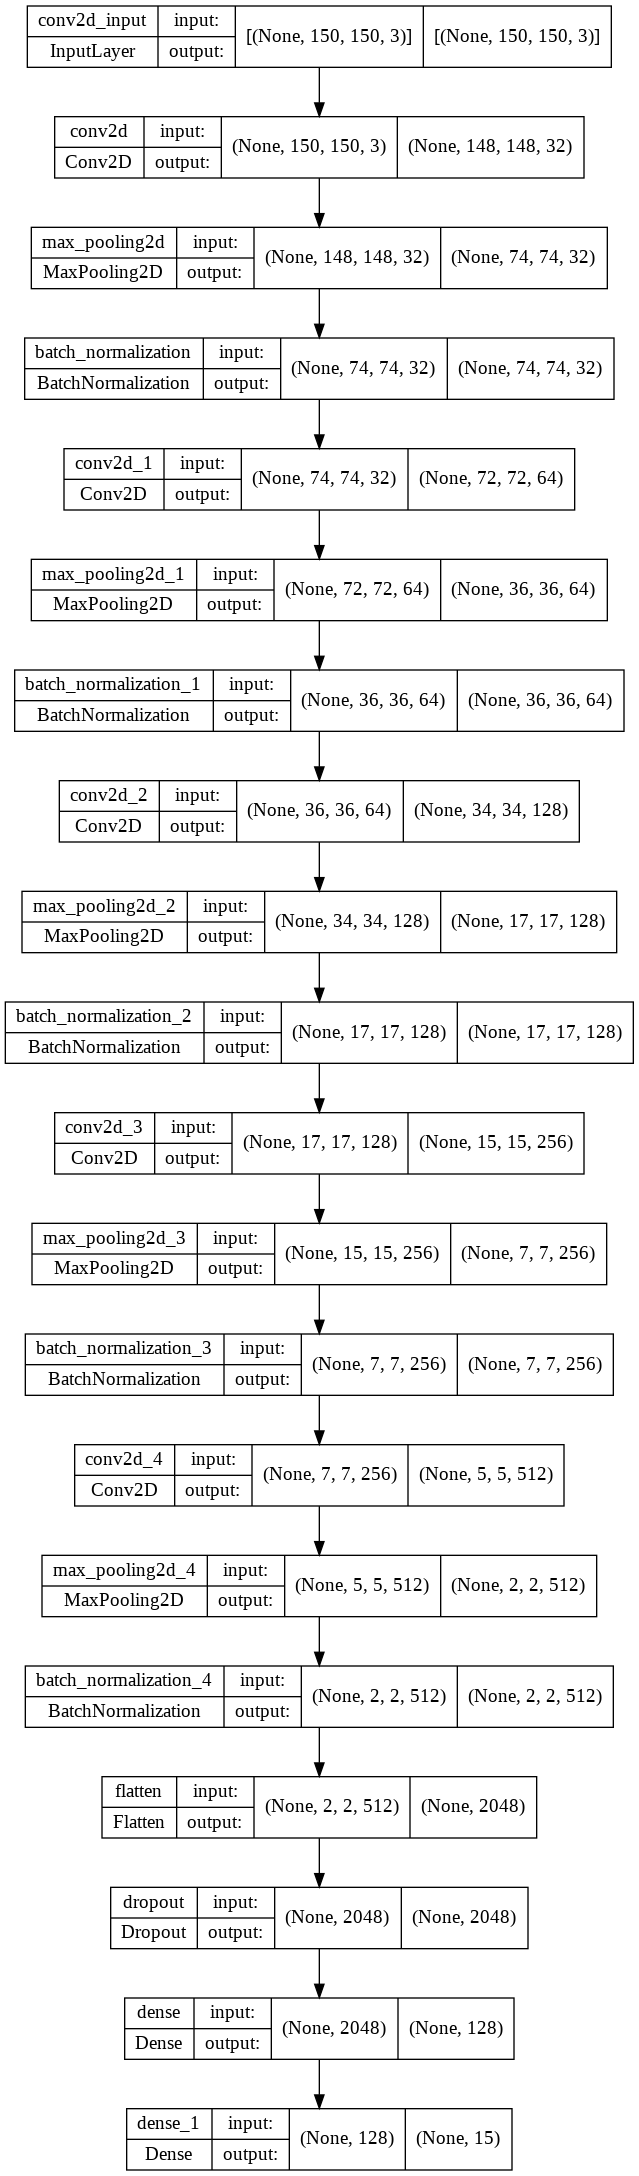

In [ ]:
## CNN model - Baseline
tf.keras.backend.clear_session()
img_width = 150
img_height = 150
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, (3, 3), strides=(1, 1), padding="valid", activation="relu", input_shape=(img_width, img_height, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2),strides=None, padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(activation = 'relu', units = 128))
cnn_model.add(Dense(activation = 'softmax', units = 15))
print(cnn_model.summary())
tf.keras.utils.plot_model(cnn_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 5.2 - Baseline CNN: Compile parameters

Learning Rate — As we train the model, our aim for stochastic gradient descent is to minimize loss among actual and predicted values of training set. The path to minimize loss takes several steps. Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters.

Loss function — Since it is a classification model for predicting more than 1 class, we will use categorical crossentropy during training for evaluation of losses.

Metrics — Accuracy — This metric is to calculate how often actual labels are equal to predictions. It will measure the loss and accuracy of training and validation.

In [ ]:
##  CNN model compilation and Training
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 5, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-3, mode='min', restore_best_weights=True)
callbacks_list = [es, learning_rate_reduction]


train_augmented = ImageDataGenerator(
    rotation_range=40,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_augmented = ImageDataGenerator(
    rotation_range=40,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

history_cnn = cnn_model.fit(train_augmented.flow(X_train, y_train, batch_size=128, shuffle=True,),
                      validation_data=val_augmented.flow(X_val, y_val, batch_size=128, shuffle=True,),
                      validation_steps=25,
                      epochs=10,
                      batch_size = 128,
                      steps_per_epoch= 25,
                      callbacks = callbacks_list,
                      verbose=1)
                        

Epoch 1/10
25/25 [==============================] - 48s 2s/step - loss: 2.1497 - accuracy: 0.4900 - val_loss: 2.3901 - val_accuracy: 0.2850 - lr: 1.0000e-04
Epoch 2/10
25/25 [==============================] - 45s 2s/step - loss: 1.6588 - accuracy: 0.6472 - val_loss: 2.0551 - val_accuracy: 0.6319 - lr: 1.0000e-04
Epoch 3/10
25/25 [==============================] - 46s 2s/step - loss: 1.5535 - accuracy: 0.6478 - val_loss: 2.0348 - val_accuracy: 0.5984 - lr: 1.0000e-04
Epoch 4/10
25/25 [==============================] - 45s 2s/step - loss: 1.6002 - accuracy: 0.6447 - val_loss: 1.7716 - val_accuracy: 0.6641 - lr: 1.0000e-04
Epoch 5/10
25/25 [==============================] - 54s 2s/step - loss: 1.6043 - accuracy: 0.6403 - val_loss: 1.6338 - val_accuracy: 0.6675 - lr: 1.0000e-04
Epoch 6/10
25/25 [==============================] - 55s 2s/step - loss: 1.5417 - accuracy: 0.6537 - val_loss: 1.5360 - val_accuracy: 0.6669 - lr: 1.0000e-04
Epoch 7/10
25/25 [==============================] - 55s 2s

## **5.3 - Baseline CNN: Training History and Performance Metrics**

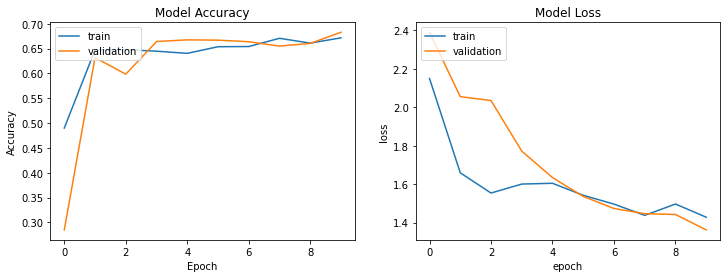

In [ ]:
## plot CNN model history for accuracy and loss
def plot_loss(model_history, out_file = None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    ## summarize history for accuracy
    ax[0].plot(history_cnn.history['accuracy'])
    ax[0].plot(history_cnn.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history_cnn.history['loss'])
    ax[1].plot(history_cnn.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')

    plt.show()
    
    if out_file:
        plt.savefig(out_file)

plot_loss(model_history = history_cnn);

In [ ]:
## Saving the model and weights(v3)
# cnn_model.save('/content/drive/Shareddrives/cs109b Project/cnn_model_xray.h5')
# cnn_model.save_weights('/content/drive/Shareddrives/cs109b Project/cnn_model_xray_weights.hdf5')
cnn_model = load_model('/content/drive/Shareddrives/cs109b Project/model_v3/cnn_model_xray.h5')

In [ ]:
# Train Accuracy Evaluation
train_accuracy_model1 = cnn_model.evaluate(X_train, y_train)
print('Train Accuracy:', round(train_accuracy_model1[1]*100, 2))

# Validation Accuracy Evaluation
validation_accuracy_model1 = cnn_model.evaluate(X_val, y_val)
print('Validation Accuracy:', round(validation_accuracy_model1[1]*100, 2))

1431/1431 [==============================] - 106s 74ms/step - loss: 1.4844 - accuracy: 0.6734
Train Accuracy: 67.34
405/405 [==============================] - 29s 71ms/step - loss: 1.5248 - accuracy: 0.6631
Validation Accuracy: 66.31


In [ ]:
# Train data Prediction
predicted_classes_cnn_train = cnn_model.predict(X_train)
predicted_classes_cnn_train = np.argmax(predicted_classes_cnn_train,axis=1)

y_train_true = np.argmax(y_train, axis=1)

In [ ]:
## train data
np.unique(predicted_classes_cnn_train)

array([ 0,  4,  8, 10, 11, 12, 14])

In [ ]:
# test accuracy
evaluation = cnn_model.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(round(evaluation[1]*100, 2)))
predicted_classes_cnn_test = cnn_model.predict(X_test)
predicted_classes_cnn_test = np.argmax(predicted_classes_cnn_test,axis=1)
predicted_classes_cnn_test

y_test_true = np.argmax(y_test, axis=1)

1019/1019 [==============================] - 78s 76ms/step - loss: 1.6646 - accuracy: 0.6319
Test Accuracy: 63.19


In [ ]:
## (test data)
np.unique(predicted_classes_cnn_test)

array([ 0,  8, 10, 11, 12, 14])

## 5.4 - Baseline CNN: Confusion Matrix

In [ ]:
# Confusion matrix and Classification report (test data)
print(metrics.confusion_matrix(y_test_true,predicted_classes_cnn_test))
print(classification_report(y_true=y_test_true, y_pred=predicted_classes_cnn_test, target_names =['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
         'Effusion', 'Emphysema', 'Fibrosis', 'Hernia','Infiltration',
         'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']))

[[    3     0     0     0     0     0     0     0     0     0  1596     3
      0     0     0]
 [    3     0     0     0     0     0     0     0     1     0   381     6
      0     0     0]
 [    1     0     0     0     0     0     0     0     0     0   571     1
      0     0     0]
 [    0     0     0     0     0     0     0     0     1     0   286     1
      0     0     0]
 [    8     0     0     0     0     0     0     0     2     0  1543     4
      1     0     0]
 [    1     0     0     0     0     0     0     0     0     0   334     0
      0     0     0]
 [    0     0     0     0     0     0     0     0     0     0   256     3
      0     0     0]
 [    1     0     0     0     0     0     0     0     0     0    33     0
      0     0     0]
 [   11     0     0     0     0     0     0     0     2     0  3643    25
      1     0     1]
 [    1     0     0     0     0     0     0     0     0     0   764     1
      0     0     0]
 [   43     0     0     0     0     0     0     0 

<AxesSubplot:>

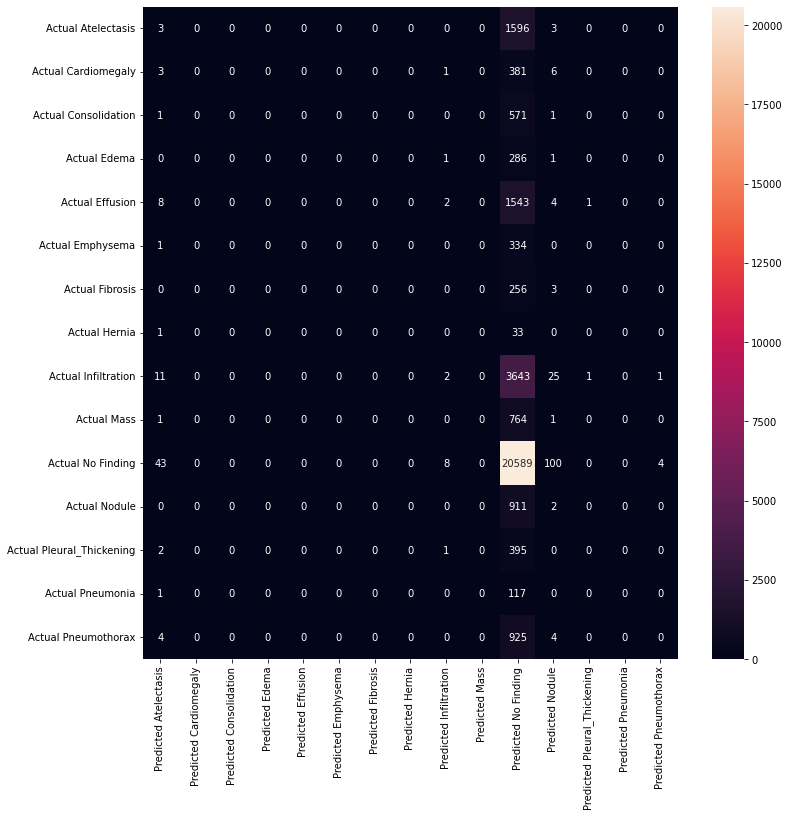

In [ ]:
## Confusion matrix (test data)
c_m = pd.DataFrame(data=confusion_matrix(y_test_true, predicted_classes_cnn_test),
                  index=['Actual Atelectasis', 'Actual Cardiomegaly', 'Actual Consolidation',
                          'Actual Edema','Actual Effusion', 'Actual Emphysema', 'Actual Fibrosis', 'Actual Hernia',
                          'Actual Infiltration', 'Actual Mass', 'Actual No Finding', 'Actual Nodule', 'Actual Pleural_Thickening', 'Actual Pneumonia', 
                          'Actual Pneumothorax'],
                  columns=['Predicted Atelectasis', 'Predicted Cardiomegaly', 'Predicted Consolidation',
                          'Predicted Edema','Predicted Effusion', 'Predicted Emphysema', 'Predicted Fibrosis', 'Predicted Hernia',
                          'Predicted Infiltration', 'Predicted Mass', 'Predicted No Finding', 'Predicted Nodule', 'Predicted Pleural_Thickening', 'Predicted Pneumonia', 
                          'Predicted Pneumothorax'])

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(c_m,annot=True,fmt="d", ax=ax)

## 5.5 - Baseline CNN: Feature Maps

Feature maps are generated by applying Filters or Feature detectors to the input image or the feature map output of the prior layers. Feature map visualization will provide insight into the internal representations for specific input for each of the Convolutional layers in the model.

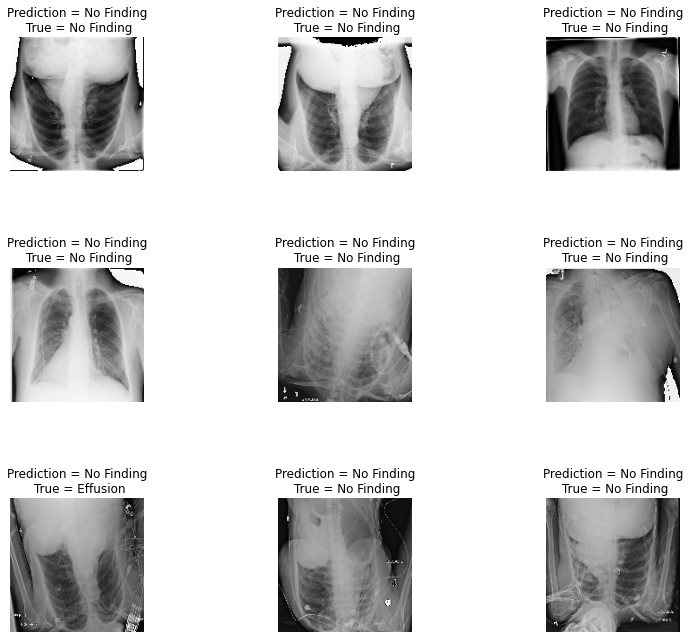

In [ ]:
## plot first few images  (test data)
xray_imgdict = {
    0 : 'Atelectasis',
    1 : 'Cardiomegaly',
    2 : 'Consolidation',
    3 : 'Edema',
    4 : 'Effusion',
    5 : 'Emphysema',
    6 : 'Fibrosis',
    7 : 'Hernia',
    8 : 'Infiltration',
    9 : 'Mass',
    10 : 'No Finding',
    11 : 'Nodule',
    12 : 'Pleural_Thickening',
    13 : 'Pneumonia',
    14 : 'Pneumothorax',

}

L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (12, 12))
ax = axes.ravel()
for i in np.arange(0, L*W):
    # ax[i].imshow(X_test[i])
    ax[i].imshow((X_test[i] * 1).astype(np.uint8))
    ax[i].set_title('Prediction = {}\n True = {}'.format(xray_imgdict[predicted_classes_cnn_test[i]], xray_imgdict[y_test_true[i]]))
    ax[i].axis('off')
plt.subplots_adjust(wspace = 1)

32
conv2d
max_pooling2d
batch_normalization
conv2d_1
max_pooling2d_1
batch_normalization_1
conv2d_2
max_pooling2d_2
batch_normalization_2
conv2d_3
max_pooling2d_3
batch_normalization_3
conv2d_4
max_pooling2d_4
batch_normalization_4
flatten
dropout
dense
dense_1


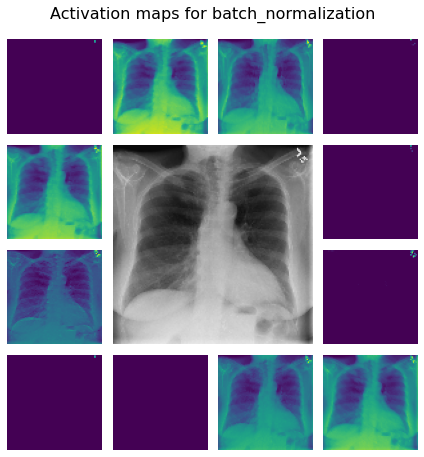

In [ ]:
## Activation maps for CNN baseline model
index = 32 ##np.random.randint(0, 50) ## # pick a random number from 0 to 10 -- 6
print(index)
out_idx = y_test[index]


def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    # axbig.imshow(img.squeeze() + 0.5)
    axbig.imshow(img.squeeze())
    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i], cmap='viridis') 
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Activation maps for {layer_names[0]}',size=16,y=1.05);

layers_list_131 = cnn_model.layers
print('\n'.join([layer.name for layer in layers_list_131]))

layer_output = cnn_model.layers[2].output
activation_model = Model(inputs=cnn_model.input, outputs=layer_output)

X_test_cnni = X_test[index].reshape(1,150,150,3)
img = ((X_test_cnni * 1).astype(np.uint8))
activations = activation_model.predict(img)
plot_featuremaps(img,activations,[cnn_model.layers[2].name])


## 5.6 - Baseline CNN: Saliency Maps

Saliency maps was first introduced in the paper: Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps. In Saliency map, we compute the gradient of output category with respect to input image. This should tell us how output category value changes with respect to a small change in input image pixels. All the positive values in the gradients tell us that a small change to that pixel will increase the output value. 

Hence, visualizing these gradients, which are the same shape as the image should provide some intuition of attention. The idea behind saliency is pretty simple in hindsight. We compute the gradient of output category with respect to input image.We can use these gradients to highlight input regions that cause the most change in the output. Intuitively this should highlight salient image regions that most contribute towards the output.



1015


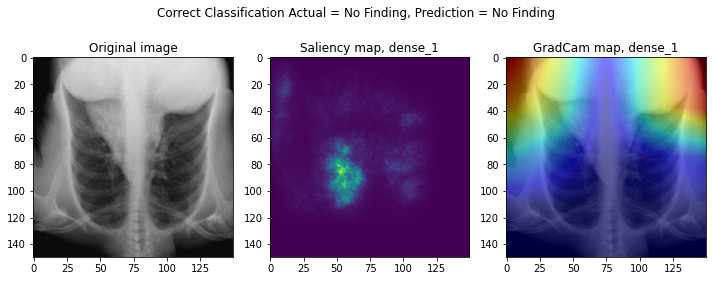

In [ ]:
# Generate saliency and Gradcam map with smoothing (for correct classification)
index = 1015 ##np.random.randint(0, 100) # pick a random number from 0 to 100
print(index)
X_test_1411i = np.expand_dims(X_test[index], axis=0)

score = lambda outputs: (outputs[0][predicted_classes_cnn_test[index]])
layr_nm = cnn_model.layers[-1].name
saliency = Saliency(cnn_model, clone=True)
saliency_map = saliency(score, X_test_1411i, smooth_samples=20, smooth_noise=0.20)

# Generate heatmap with GradCAM
gradcam = Gradcam(cnn_model, clone=True)
cam = gradcam(score, X_test[index], penultimate_layer=-1)
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

# plot and render the images
fig, ax = plt.subplots(1,3, figsize=(10, 4))
input_image = ((X_test[index] * 1).astype(np.uint8))
ax[0].imshow(input_image)
fig.suptitle('Correct Classification Actual = {}, Prediction = {}'.format(xray_imgdict[y_test_true[index]], xray_imgdict[predicted_classes_cnn_test[index]]), fontsize=12)
ax[0].set_title('Original image')
ax[1].imshow(saliency_map[0], cmap='viridis')
ax[1].set_title(f'Saliency map, {layr_nm}')
ax[2].imshow(input_image.sum(axis=2), cmap='gray')
ax[2].imshow(heatmap, cmap='viridis', alpha = 0.5)
ax[2].set_title(f'GradCam map, {layr_nm}')
plt.tight_layout()
plt.show()  

## 5.7 - Baseline CNN: Grad CAM 
Gradient-weighted Class Activation Mapping (Grad-CAM), uses the class-specific gradient information flowing into the final convolutional layer of a CNN to
produce a coarse localization map of the important regions in the image. Grad-CAM is a strict generalization of the Class Activation Mapping (CAM). While CAM is limited to a narrow class of CNN models, Grad-CAM is broadly
applicable to any CNN-based architectures. 

In the context of image classification models, visualizations lend insight into failure modes of these models (showing that seemingly unreasonable predictions have reasonable explanations), and outperform pixel-space gradient visualizations. Guided Grad-CAM explanations help in the predictions made by deep networks.

Predicted class for the image, 10
Actual class for the image, 14


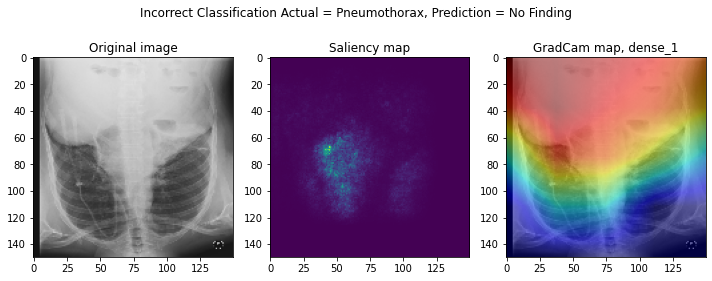

In [ ]:
## Generate saliency and Gradcam map with smoothing (for incorrect classification)
index_cnn = 45  ##6
out_idx_cnn = y_test_true[index_cnn]
pred_out_idx_cnn = predicted_classes_cnn_test[index_cnn]
print(f'Predicted class for the image, {pred_out_idx_cnn}')
print(f'Actual class for the image, {out_idx_cnn}')

# Generate saliency map with smoothing
X_test_cnni = np.expand_dims(X_test[index_cnn], axis=0)
score = lambda outputs: (outputs[0][predicted_classes_cnn_test[index_cnn]])
saliency = Saliency(cnn_model, clone=True)
saliency_map = saliency(score, X_test_cnni, smooth_samples=20, smooth_noise=0.50)

# Generate heatmap with GradCAM
gradcam = Gradcam(cnn_model, clone=True)
layr_nm = cnn_model.layers[-1].name
cam = gradcam(score, X_test_cnni, penultimate_layer=-1)
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

# plot and render the images
fig, ax = plt.subplots(1,3, figsize=(10, 4))
input_image = ((X_test[index_cnn] * 1).astype(np.uint8))
ax[0].imshow(input_image)
fig.suptitle('Incorrect Classification Actual = {}, Prediction = {}'.format(xray_imgdict[out_idx_cnn], xray_imgdict[pred_out_idx_cnn]), fontsize=12)
ax[0].set_title('Original image')
ax[1].imshow(saliency_map[0], cmap='viridis')
ax[1].set_title('Saliency map')
ax[2].imshow(input_image.sum(axis=2), cmap='gray')
ax[2].imshow(heatmap, cmap='viridis', alpha = 0.5)
ax[2].set_title(f'GradCam map, {layr_nm}')
plt.tight_layout()
plt.show()


## **5.8 - Baseline CNN: Discussion of Results**

As we can see from the plotting of the model training history and the resulting performance metrics on the test set, the baseline CNN model shows decent results with training accuracy of 67.3%, validation accuracy of 66.3%, and test accuracy of 63.2%.

However, upon further inspection of the confusion matrix, we can observe that the model is largely predicting the "no finding" class, which itself makes up 63% of the test dataset, thus the model seems to be over fitting to the no finding images. We can observe from the two minority classes that were predicted by the model (although with low accuracy), Atelectasis and Nodule, that they can be considered a rather "large" minority class, representing 3% of the dataset.

Additionally, we introduce a discussion about the relevancy of the labels in the conclusion section of this report. To summarize quickly, independent audits by a radiologist call into question the relevance of chest x-ray imaging to the diagnosis of some of the disease labels in the dataset. The radiologist mentions that many of the disease labels are not diagnosed through x-ray imaging, but through other clinical means.

We broach this subject in this section to highlight the fact that the Baseline CNN model does predicts two labels that we know for certainty are diagnosed with x-ray imaging (as mentioned above, the disease labels Atelectasis and Nodule). According to Mayo Clinic and Cleveland Clinic, Atelectasis and Pulmonary Nodules are diagnosed with x-ray images.

This suggests that the Baseline CNN model may be learning distinct features of the various disease labels. We move onto Transfer learning models in the next section to see if other architectures can produce better results.

---
# **6. Transfer Learning Models**

In transfer learning, we use an existing model to solve different but related problems. Basically, we try to exploit what was learned in one task and improve generalization in another task. We use the model’s pre-trained weights and model architecture to solve the classification problem. 

In this project, we are using the pre-trained weights of VGG19 and ResNet50, change the output layer and solve a classification problem on the X-ray dataset.

As a viable alternative we are using the pre-trained models like VGG19 and ResNet50 that have been used successfully as a baseline for transfer learning in a variety of computer vision tasks

Typical Transfer Learning Workflow:
1.   Instantiate a base model and load pre-trained weights into it.
2.   Freeze all layers in the base model by setting trainable = False.
3.   Create a new model on top of the output of one (or several) layers from the base model.
4.   Train your new model on your new dataset.

---
# **7. VGG19 Model**

Discussion of results in section 7.7 below.


## **7.1 - VGG19: Architecture**

VGG-19 is a convolutional neural network that is 19 layers deep. We load a pretrained version of the network trained on more than a million images from the ImageNet database. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224. We are specifying include_top=False so optional shape tuple, is specified (150-by-150)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

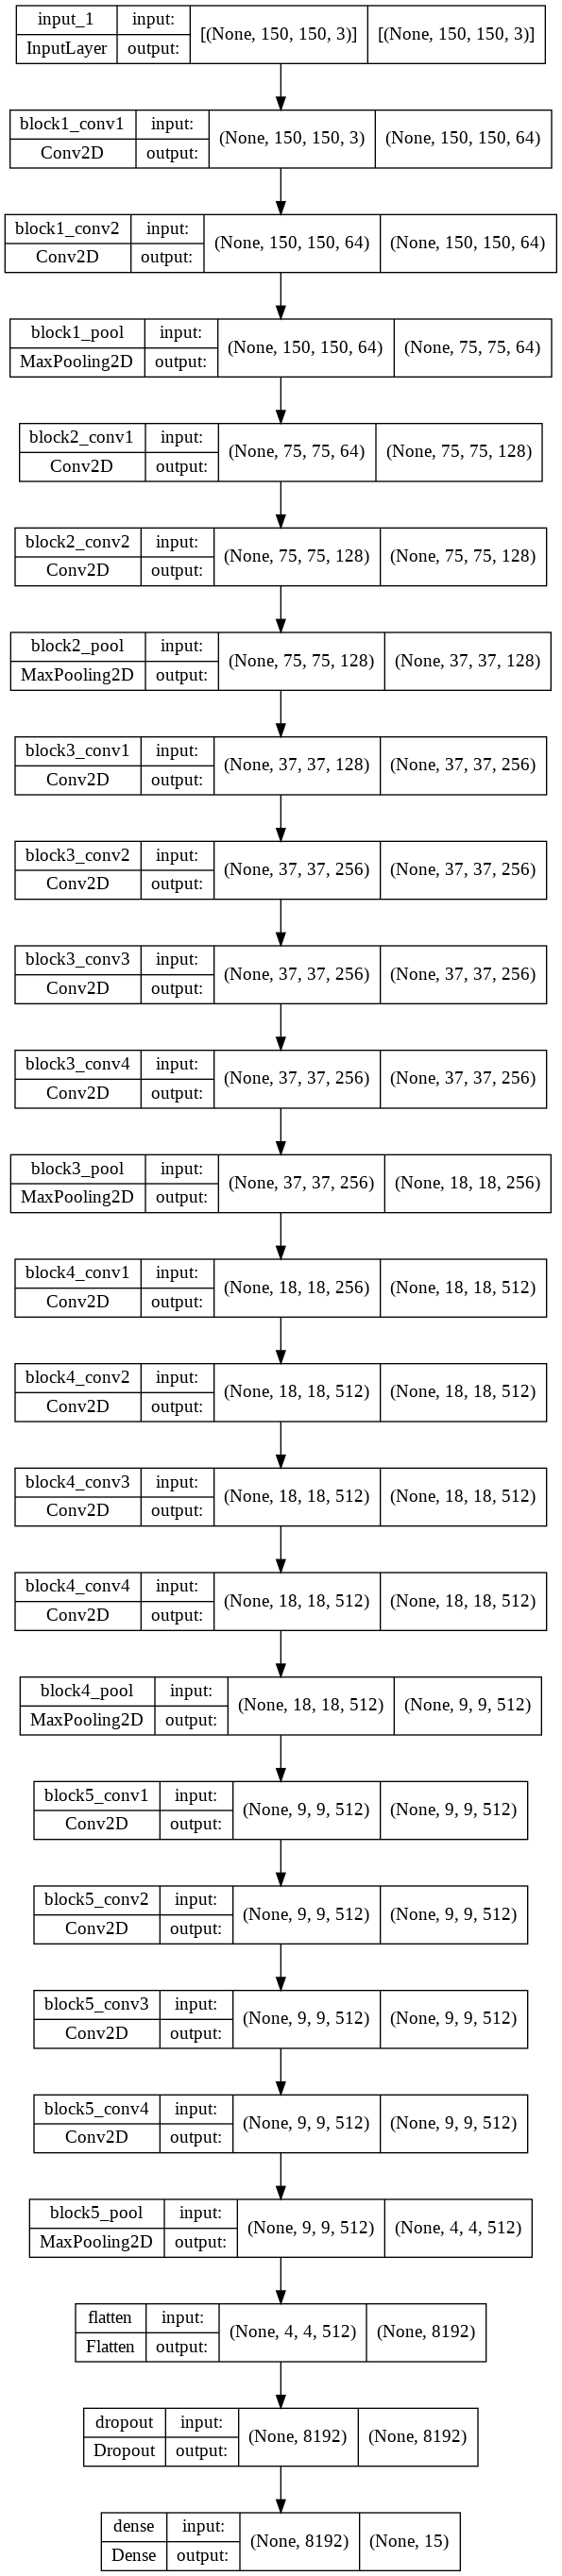

In [ ]:
tf.keras.backend.clear_session()
## vgg19  model Classification

vggModel = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))

for layer in vggModel.layers:
    layer.trainable = False
    
outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs) ###(use for imagenet weights)
outputs = Dropout(0.3)(outputs)
outputs = Dense(15, activation="softmax")(outputs)

vgg_model = Model(inputs=vggModel.input, outputs=outputs)
print(vgg_model.summary())

vgg_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
)
tf.keras.utils.plot_model(vgg_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False)

## **7.2 - VGG19: Compile parameters**

Learning Rate — As we train the model, our aim for stochastic gradient descent is to minimize loss among actual and predicted values of training set. The path to minimize loss takes several steps. Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters.The model was trained with a lower learning rate as we trained a much larger model. It is critical to do this step after the model with frozen layers has been trained to convergence. We also want to readapt the pretrained weights in an incremental way.

Loss function — Since it is a classification model for predicting more than 1 class, we will use categorical crossentropy during training for evaluation of losses.

Metrics — Accuracy — This metric is to calculate how often actual labels are equal to predictions. It will measure the loss and accuracy of training and validation.

After the model has converged on the new data, all or part of the base model was unfreezed and retrained the whole model end-to-end with a very low learning rate. It lead to overfitting and we just ran it without further fine tuning.


In [ ]:
## Augmentation and training for VGG19 model
train_augmented = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2, 
    zoom_range = 0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=1e-5, verbose=1)

history_vgg = vgg_model.fit(train_augmented.flow(X_train, y_train, batch_size=256),
                    validation_data=(X_val, y_val),
                    epochs=5,
                    callbacks = [reduce_lr],
                    verbose=1)

Epoch 1/5
179/179 [==============================] - 1290s 7s/step - loss: 1.4198 - accuracy: 0.6692 - val_loss: 28.9693 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 2/5
179/179 [==============================] - 1197s 7s/step - loss: 1.3509 - accuracy: 0.6756 - val_loss: 37.0617 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 3/5
179/179 [==============================] - 1205s 7s/step - loss: 1.3395 - accuracy: 0.6754 - val_loss: 40.9550 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 4/5
179/179 [==============================] - ETA: 0s - loss: 1.3315 - accuracy: 0.6757
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
179/179 [==============================] - 1197s 7s/step - loss: 1.3315 - accuracy: 0.6757 - val_loss: 41.3215 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 5/5
179/179 [==============================] - 1225s 7s/step - loss: 1.3222 - accuracy: 0.6760 - val_loss: 41.0665 - val_accuracy: 0.6608 - lr: 8.0000e-04


## **7.3 - VGG19: Training History and Performance Metrics**

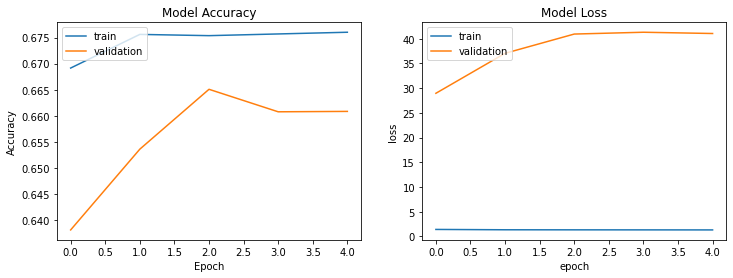

In [ ]:
def plot_loss(model_history, out_file = None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    
    ax[0].plot(history_vgg.history['accuracy'])
    ax[0].plot(history_vgg.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history_vgg.history['loss'])
    ax[1].plot(history_vgg.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')


    plt.show()
    
    if out_file:
        plt.savefig(out_file)

plot_loss(model_history = history_vgg);

In [ ]:
## vgg model (v3)
# vgg_model.save('/content/drive/Shareddrives/cs109b Project/vgg_xray.h5')
# vgg_model.save_weights('/content/drive/Shareddrives/cs109b Project/vgg_xray_weights.hdf5')
vgg_model = load_model('/content/drive/Shareddrives/cs109b Project/model_v3/vgg_xray.h5')

In [ ]:
# Train
train_accuracy_vgg = vgg_model.evaluate(X_train, y_train)
print('Train Accuracy:', round(train_accuracy_vgg[1]*100, 2))

# Validation
validation_accuracy_vgg = vgg_model.evaluate(X_val, y_val)
print('Validation Accuracy:', round(validation_accuracy_vgg[1]*100, 2))

1431/1431 [==============================] - 1026s 716ms/step - loss: 40.8495 - accuracy: 0.6700
Train Accuracy: 67.0
405/405 [==============================] - 264s 650ms/step - loss: 41.4556 - accuracy: 0.6587
Validation Accuracy: 65.87


In [ ]:
#training prediction
predicted_classes_vgg_train = vgg_model.predict(X_train)
predicted_classes_vgg_train = np.argmax(predicted_classes_vgg_train,axis=1)

y_train_true = np.argmax(y_train, axis=1)

In [ ]:
## train data prediction class Labels
np.unique(predicted_classes_vgg_train)

array([ 0,  4,  8,  9, 10, 11, 14])

In [ ]:
# test accuracy
evaluation_vgg = vgg_model.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(round(evaluation_vgg[1]*100, 2)))
predicted_classes_vgg_test = vgg_model.predict(X_test)
predicted_classes_vgg_test = np.argmax(predicted_classes_vgg_test,axis=1)
predicted_classes_vgg_test

y_test_true = np.argmax(y_test, axis=1)

1019/1019 [==============================] - 668s 655ms/step - loss: 45.7495 - accuracy: 0.6291
Test Accuracy: 62.91


In [ ]:
## vgg model - test data labels prediction
np.unique(predicted_classes_vgg_test)

array([ 0,  3,  4,  8,  9, 10, 11, 14])

## **7.4 - VGG19: Confusion Matrix**


In [ ]:
## Confusion matrix and classification report for VGG model (test data)
print(metrics.confusion_matrix(y_test_true,predicted_classes_vgg_test))
print(classification_report(y_true=y_test_true, y_pred=predicted_classes_vgg_test, target_names =['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
         'Effusion', 'Emphysema', 'Fibrosis', 'Hernia','Infiltration',
         'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']))

[[    0     0     0     0     1     0     0     0    19     0  1572    10
      0     0     0]
 [    0     0     0     0     1     0     0     0     8     0   380     2
      0     0     0]
 [    0     0     0     0     0     0     0     0    12     0   559     2
      0     0     0]
 [    0     0     0     0     1     0     0     0     4     0   278     5
      0     0     0]
 [    1     0     0     1     4     0     0     0    18     0  1517    16
      0     0     1]
 [    0     0     0     0     0     0     0     0     5     0   329     1
      0     0     0]
 [    0     0     0     0     1     0     0     0     7     0   250     1
      0     0     0]
 [    0     0     0     0     0     0     0     0     0     0    34     0
      0     0     0]
 [    0     0     0     0     6     0     0     0    56     1  3590    29
      0     0     1]
 [    0     0     0     0     1     0     0     0     7     0   751     6
      0     0     1]
 [    9     0     0     1    17     0     0     0 

<AxesSubplot:>

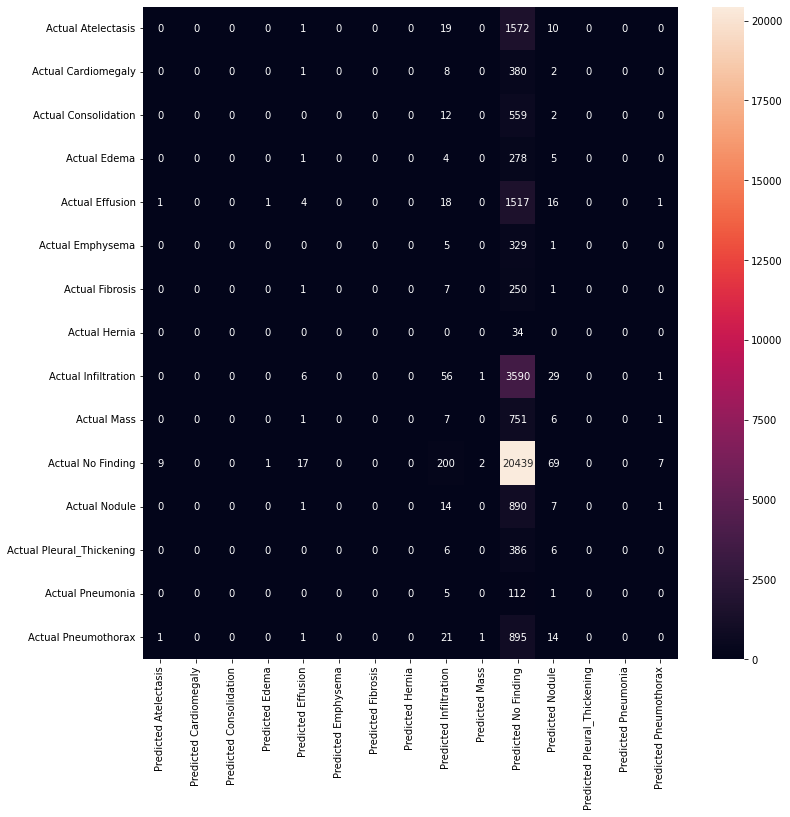

In [ ]:
## Confusion matrix (test data)
c_m_vgg = pd.DataFrame(data=confusion_matrix(y_test_true, predicted_classes_vgg_test),
                  index=['Actual Atelectasis', 'Actual Cardiomegaly', 'Actual Consolidation',
                          'Actual Edema','Actual Effusion', 'Actual Emphysema', 'Actual Fibrosis', 'Actual Hernia',
                          'Actual Infiltration', 'Actual Mass', 'Actual No Finding', 'Actual Nodule', 'Actual Pleural_Thickening', 'Actual Pneumonia', 
                          'Actual Pneumothorax'],
                  columns=['Predicted Atelectasis', 'Predicted Cardiomegaly', 'Predicted Consolidation',
                          'Predicted Edema','Predicted Effusion', 'Predicted Emphysema', 'Predicted Fibrosis', 'Predicted Hernia',
                          'Predicted Infiltration', 'Predicted Mass', 'Predicted No Finding', 'Predicted Nodule', 'Predicted Pleural_Thickening', 'Predicted Pneumonia', 
                          'Predicted Pneumothorax'])

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(c_m_vgg,annot=True,fmt="d", ax=ax)

## **7.5 - VGG19: Feature Maps**


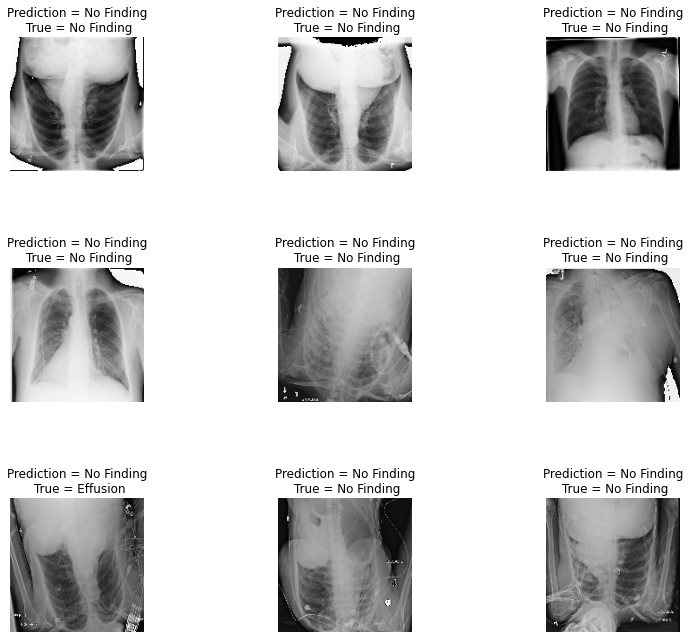

In [ ]:
## plot first few images for prediction (test data)
xray_imgdict = {
    0 : 'Atelectasis',
    1 : 'Cardiomegaly',
    2 : 'Consolidation',
    3 : 'Edema',
    4 : 'Effusion',
    5 : 'Emphysema',
    6 : 'Fibrosis',
    7 : 'Hernia',
    8 : 'Infiltration',
    9 : 'Mass',
    10 : 'No Finding',
    11 : 'Nodule',
    12 : 'Pleural_Thickening',
    13 : 'Pneumonia',
    14 : 'Pneumothorax',

}

L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (12, 12))
ax = axes.ravel()
for i in np.arange(0, L*W):
    ax[i].imshow((X_test[i] * 1).astype(np.uint8))
    ax[i].set_title('Prediction = {}\n True = {}'.format(xray_imgdict[predicted_classes_vgg_test[i]], xray_imgdict[y_test_true[i]]))
    ax[i].axis('off')
plt.subplots_adjust(wspace = 1)

6
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
dropout
dense


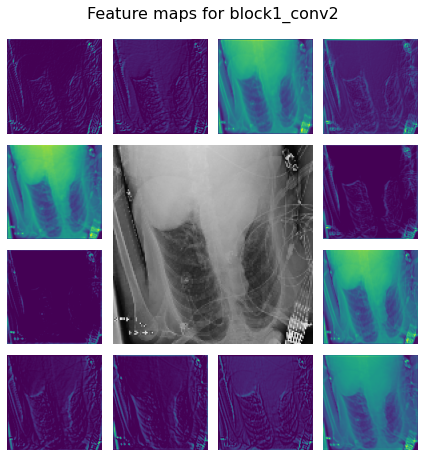

In [ ]:
index_vgg = 6 ##np.random.randint(0, 50) ## # pick a random number from 0 to 10 -- 19
print(index_vgg)
out_idx_vgg = y_test[index_vgg]


def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    # axbig.imshow(img.squeeze() + 0.5)
    axbig.imshow(img.squeeze())
    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i], cmap='viridis')
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Feature maps for {layer_names[0]}',size=16,y=1.05);

layers_list_vgg = vgg_model.layers
print('\n'.join([layer.name for layer in layers_list_vgg]))

layer_output_vgg = vgg_model.layers[2].output
activation_model_vgg = Model(inputs=vgg_model.input, outputs=layer_output_vgg)

X_test_vggi = X_test[index_vgg].reshape(1,150,150,3)
img = ((X_test_vggi * 1).astype(np.uint8))
activations_vgg = activation_model_vgg.predict(img)
plot_featuremaps(img,activations_vgg,[vgg_model.layers[2].name])


## **7.6 - VGG19: Saliency Maps and GradCAM**

1035


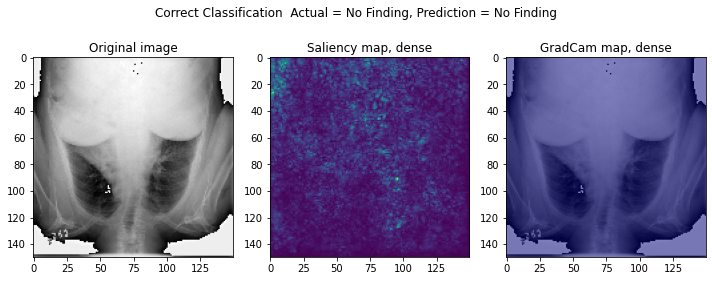

In [ ]:
# Generate saliency map with smoothing for vgg model
# Generate saliency and Gradcam map with smoothing (for correct classification)
index_vgg = 1035 ##np.random.randint(0, 10000) # pick a random number from 0 to 10000 - 558
print(index_vgg)

# Generate saliency map with smoothing
X_test_vggi = np.expand_dims(X_test[index_vgg], axis=0)
layr_nm = vgg_model.layers[-1].name
score_vgg = lambda outputs: (outputs[0][predicted_classes_vgg_test[index_vgg]])
saliency = Saliency(vgg_model, clone=True)
saliency_map_vgg = saliency(score_vgg, X_test_vggi, smooth_samples=20, smooth_noise=0.50)

# Generate heatmap with GradCAM
gradcam = Gradcam(vgg_model, clone=True)
cam = gradcam(score_vgg, X_test_vggi, penultimate_layer=-1)
heatmap_vgg = np.uint8(cm.jet(cam[0])[..., :3] * 255)

# plot and render the images
fig, ax = plt.subplots(1,3, figsize=(10, 4))
input_image_vgg = ((X_test[index_vgg] * 1).astype(np.uint8))
ax[0].imshow(input_image_vgg)
fig.suptitle('Correct Classification  Actual = {}, Prediction = {}'.format(xray_imgdict[y_test_true[index_vgg]], xray_imgdict[predicted_classes_vgg_test[index_vgg]]), fontsize=12)
ax[0].set_title('Original image')
ax[1].imshow(saliency_map_vgg[0], cmap='viridis')
ax[1].set_title(f'Saliency map, {layr_nm}')
ax[2].imshow(input_image_vgg.sum(axis=2), cmap='gray')
ax[2].imshow(heatmap_vgg, cmap='viridis', alpha = 0.5)
ax[2].set_title(f'GradCam map, {layr_nm}')
plt.tight_layout()
plt.show()

45


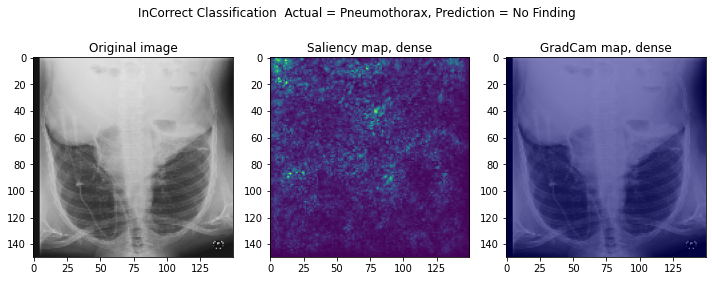

In [ ]:
# Generate saliency and Gradcam map with smoothing (for Incorrect classification)
index_vgg = 45 ##np.random.randint(0, 10000) # pick a random number from 0 to 10000 - 1025
print(index_vgg)

# Generate saliency map with smoothing
X_test_vggi = np.expand_dims(X_test[index_vgg], axis=0)
layr_nm = vgg_model.layers[-1].name
score_vgg = lambda outputs: (outputs[0][predicted_classes_vgg_test[index_vgg]])
saliency = Saliency(vgg_model, clone=True)
saliency_map_vgg = saliency(score_vgg, X_test_vggi, smooth_samples=20, smooth_noise=0.50)

# Generate heatmap with GradCAM
gradcam = Gradcam(vgg_model, clone=True)
cam = gradcam(score_vgg, X_test_vggi, penultimate_layer=-1)
heatmap_vgg = np.uint8(cm.jet(cam[0])[..., :3] * 255)

# plot and render the images
fig, ax = plt.subplots(1,3, figsize=(10, 4))
input_image_vgg = ((X_test[index_vgg] * 1).astype(np.uint8))
ax[0].imshow(input_image_vgg)
fig.suptitle('InCorrect Classification  Actual = {}, Prediction = {}'.format(xray_imgdict[y_test_true[index_vgg]], xray_imgdict[predicted_classes_vgg_test[index_vgg]]), fontsize=12)
ax[0].set_title('Original image')
ax[1].imshow(saliency_map_vgg[0], cmap='viridis')
ax[1].set_title(f'Saliency map, {layr_nm}')
ax[2].imshow(input_image_vgg.sum(axis=2), cmap='gray')
ax[2].imshow(heatmap_vgg, cmap='viridis', alpha = 0.5)
ax[2].set_title(f'GradCam map, {layr_nm}')
plt.tight_layout()
plt.show()


In [ ]:
## load data for the resnet50 model

X_train = np.load('/content/drive/Shareddrives/cs109b Project/model_out_v1/X_train.npy', allow_pickle=True)
y_train = np.load('/content/drive/Shareddrives/cs109b Project/model_out_v1/y_train.npy', allow_pickle=True)
X_val = np.load('/content/drive/Shareddrives/cs109b Project/model_out_v1/X_val.npy', allow_pickle=True)
y_val = np.load('/content/drive/Shareddrives/cs109b Project/model_out_v1/y_val.npy', allow_pickle=True)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


(12949, 150, 150, 3)
(12949, 15)


## **7.7 - VGG19: Discussion of Results**

As we can see from the plotting of the model training history and the resulting performance metrics on the test set, the VGG19 model shows similar but slightly worse performance than the Baseline CNN model, with training accuracy of 67.0%, validation accuracy of 65.9%, and test accuracy of 62.9%.

Further inspection of the confusion matrix shows similar issues with the model mostly predicting "No Finding" label, and this time sparsely predicting other disease labels such as Infiltration and Nodules. Infiltration and Nodules can be considered larger minority classes with 9.9% and 3.1% of the training set, respectively.

As mentioned, above regarding relevancy of disease labels to diagnosis through x-ray imaging, infiltration and nodules are often diagnosed with x-ray imaging, meaning that the VGG19 model is actually capturing some features that are distinct to these labels. Curiously, from the original paper by Wang et al. in 2017, infiltration is often associated with Atelectasis, which was a heavily predicted class by the Baseline CNN model.


---
# **8. ResNet50 Model**

Discussion of results in section 8.7 below.


## **8.1 - ResNet50: Architecture**

ResNet50 is a convolutional neural network that is 50 layers deep. We load a pretrained version of the network trained on more than a million images from the ImageNet database. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224. We are specifying include_top=False so optional shape tuple, is specified (150-by-150)

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer.

Double or triple-layer skips with nonlinearities (ReLU) and batch normalisation are used in most ResNet models. HighwayNet, a model that employ an additional weight matrix to learn the skip weights are often incorporated. ResNet-50 architecture consists of sequences of convolutional blocks with average pooling. Softmax is used as at the last layer for classification. The basic idea of ResNet50 was better explained by Quingge et al. [29], in their study for identification of macular diseases from optical coherency tomography images.

The ResNet-50 consists of five convolutional layers namely; conv1, conv2_x, conv3_x, conv4_x and conv5_x. Once the input image is loaded, it is passed through a convolutional layer with 64 filters and kernel size of 7x7 (conv1 layer) followed by a max pooling layer of stride length of 2 in both cases.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

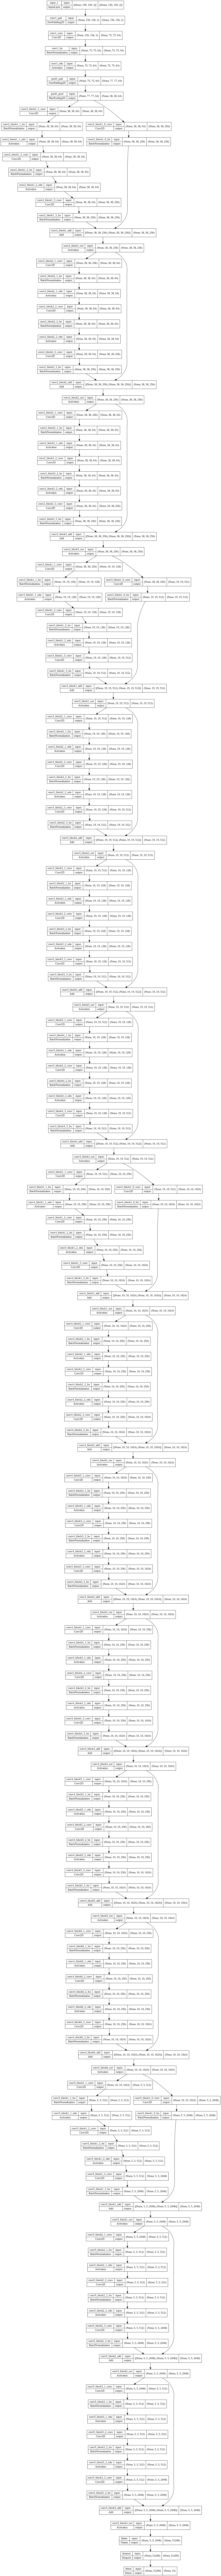

In [ ]:
tf.keras.backend.clear_session()
## REsnet50 model Classification

training_data_r = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data_r = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# ### creating data batch using ImageDatagenerator 

train_datagen = ImageDataGenerator().flow(x=X_train, y=y_train, batch_size=128, shuffle=True,)
autotune = tf.data.AUTOTUNE
train_datagen_tfdata = training_data_r.shuffle(buffer_size=30000).batch(128).prefetch(buffer_size=autotune)

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

train_data_batches = training_data_r.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=autotune)
valid_data_batches = validation_data_r.shuffle(buffer_size=10000).batch(16).prefetch(buffer_size=autotune)

## model implementation and creation
resnet50Model = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

for layer in resnet50Model.layers:
    layer.trainable = False

    
outputs = resnet50Model.output
outputs = Flatten(name="flatten")(outputs) ##(use for imagenet weights)
outputs = Dropout(0.3)(outputs)
outputs = Dense(15, activation="softmax")(outputs)

renet50_model = Model(inputs=resnet50Model.input, outputs=outputs)
print(renet50_model.summary())
tf.keras.utils.plot_model(renet50_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False)

## **8.2 ResNet50: Compile Parameters**
Learning Rate — As we train the model, our aim for stochastic gradient descent is to minimize loss among actual and predicted values of training set. The path to minimize loss takes several steps. Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters.The model was trained with a lower learning rate as we trained a much larger model. It is critical to do this step after the model with frozen layers has been trained to convergence. We also want to readapt the pretrained weights in an incremental way.

Loss function — Since it is a classification model for predicting more than 1 class, we will use categorical crossentropy during training for evaluation of losses.

Metrics — Accuracy — This metric is to calculate how often actual labels are equal to predictions. It will measure the loss and accuracy of training and validation.

The main motivation of the ResNet original work was to address the degradation problem in a deep network. Adding more layers to a sufficiently deep neural network would first see saturation in accuracy and then the accuracy degrades.

In [ ]:
## resnet50 Compilation and training

## model compilation
renet50_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=1e-5, verbose=1)

history_resnet50 = renet50_model.fit(train_data_batches,
                    validation_data = valid_data_batches, 
                    epochs=5,
                    callbacks = [reduce_lr],
                    verbose=1)


Epoch 1/5
358/358 [==============================] - 501s 1s/step - loss: 4.9290 - acc: 0.5171 - val_loss: 5.7870 - val_acc: 0.6401 - lr: 0.0010
Epoch 2/5
358/358 [==============================] - 561s 2s/step - loss: 3.6915 - acc: 0.5822 - val_loss: 5.8383 - val_acc: 0.4183 - lr: 0.0010
Epoch 3/5
358/358 [==============================] - 631s 2s/step - loss: 3.1074 - acc: 0.6246 - val_loss: 5.9710 - val_acc: 0.5916 - lr: 0.0010
Epoch 4/5
358/358 [==============================] - ETA: 0s - loss: 2.6801 - acc: 0.6608
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
358/358 [==============================] - 473s 1s/step - loss: 2.6801 - acc: 0.6608 - val_loss: 5.8518 - val_acc: 0.5515 - lr: 0.0010
Epoch 5/5
358/358 [==============================] - 597s 2s/step - loss: 2.0623 - acc: 0.7070 - val_loss: 5.6357 - val_acc: 0.5928 - lr: 8.0000e-04


## **8.3 - ResNet50: Training History and Performance Metrics**

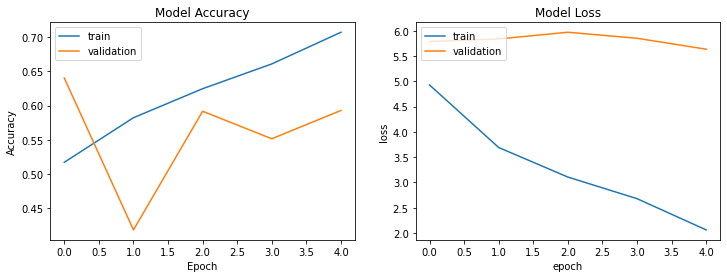

In [ ]:
## Plot training and validation loss and accuracy
def plot_loss(model_history, out_file = None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    
    ax[0].plot(history_resnet50.history['acc'])
    ax[0].plot(history_resnet50.history['val_acc'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history_resnet50.history['loss'])
    ax[1].plot(history_resnet50.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')


    plt.show()
    
    if out_file:
        plt.savefig(out_file)

plot_loss(model_history = history_resnet50);

In [ ]:
## model and save weights
# renet50_model.save('/content/drive/Shareddrives/cs109b Project/resnet50_xray.h5')
# renet50_model.save_weights('/content/drive/Shareddrives/cs109b Project/resnet50_xray_weights.hdf5')
renet50_model = load_model('/content/drive/Shareddrives/cs109b Project/model_v3/resnet50_xray.h5')

In [ ]:
# Train evaluation
train_accuracy_resnet50 = renet50_model.evaluate(X_train, y_train)
print('Train Accuracy:', round(train_accuracy_resnet50[1]*100, 2))

# Validation evaluation
validation_accuracy_resnet50 = renet50_model.evaluate(X_val, y_val)
print('Validation Accuracy:', round(validation_accuracy_resnet50[1]*100, 2))

1431/1431 [==============================] - 590s 411ms/step - loss: 0.7887 - acc: 0.8401
Train Accuracy: 84.01
405/405 [==============================] - 157s 388ms/step - loss: 5.6357 - acc: 0.5928
Validation Accuracy: 59.28


In [ ]:
## prediction on training data
predicted_classes_resnet50_train = renet50_model.predict(X_train)
predicted_classes_resnet50_train = np.argmax(predicted_classes_resnet50_train,axis=1)
predicted_classes_resnet50_train

y_train_true = np.argmax(y_train, axis=1)

In [ ]:
## Train prediction class labels
np.unique(predicted_classes_resnet50_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
# # load Test data for resnet50 model
X_test = np.load('/content/drive/Shareddrives/cs109b Project/model_out_v1/X_test.npy', allow_pickle=True)
y_test = np.load('/content/drive/Shareddrives/cs109b Project/model_out_v1/y_test.npy', allow_pickle=True)
print(X_test.shape)
print(y_test.shape)

(32595, 150, 150, 3)
(32595, 15)


In [ ]:
# test accuracy evaluation
test_data_r = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data_batches = test_data_r.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=autotune)

test_accuracy_resnet50 = renet50_model.evaluate(test_data_batches)
print('Test Accuracy: {}'.format(round(test_accuracy_resnet50[1]*100, 2)))
predicted_classes_resnet50_test = renet50_model.predict(X_test)
predicted_classes_resnet50_test = np.argmax(predicted_classes_resnet50_test,axis=1)
predicted_classes_resnet50_test

y_test_true = np.argmax(y_test, axis=1)

255/255 [==============================] - 540s 2s/step - loss: 6.1956 - acc: 0.5617
Test Accuracy: 56.17


In [ ]:
## Test prediction class labels
np.unique(predicted_classes_resnet50_test)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14])

## **8.4 - ResNet50: Confusion Matrix**

In [ ]:
## Confusion matrix and classification report for VGG model
print(metrics.confusion_matrix(y_test_true,predicted_classes_resnet50_test))
print(classification_report(y_true=y_test_true, y_pred=predicted_classes_resnet50_test, target_names =['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
         'Effusion', 'Emphysema', 'Fibrosis', 'Hernia','Infiltration',
         'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']))

[[   76    10    35     0    67     1    12     0    47    23  1289    26
      2     2    12]
 [    5    23    12     0     6     0     2     0    14     3   319     6
      1     0     0]
 [   14     2    27     1    30     3     5     0    26    12   443     9
      0     0     1]
 [    3     4    15     4    11     1     0     0    20     5   218     5
      0     2     0]
 [   55    10    82     9   192     3     4     0    59    31  1072    25
      3     3    10]
 [   10     1     6     0    10     3     5     0     5     2   282     7
      1     1     2]
 [    8     3     5     0    11     2     5     0     5     6   200    12
      0     0     2]
 [    2     0     0     0     0     0     2     0     0     0    28     2
      0     0     0]
 [   66    20   120    15   116     2    21     0   189    61  2969    83
      1     4    16]
 [   14     6    12     0    28     1     7     0    15    39   614    26
      1     0     3]
 [  401   113   368    28   480    22    99     0 

<AxesSubplot:>

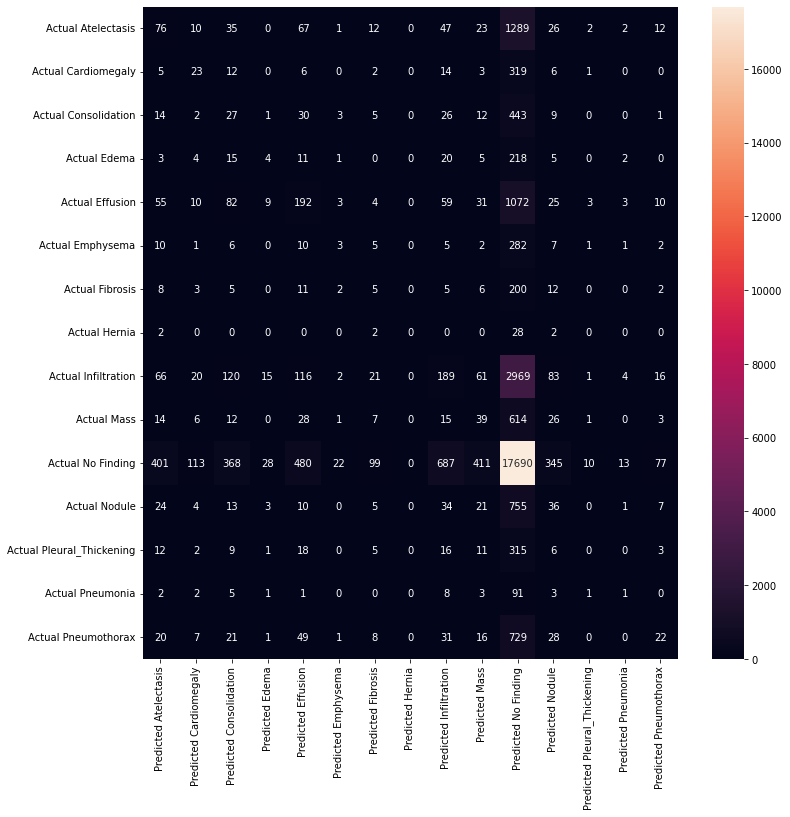

In [ ]:
## Confusion matrix
c_m_resnet50 = pd.DataFrame(data=confusion_matrix(y_test_true, predicted_classes_resnet50_test),
                  index=['Actual Atelectasis', 'Actual Cardiomegaly', 'Actual Consolidation',
                          'Actual Edema','Actual Effusion', 'Actual Emphysema', 'Actual Fibrosis', 'Actual Hernia',
                          'Actual Infiltration', 'Actual Mass', 'Actual No Finding', 'Actual Nodule', 'Actual Pleural_Thickening', 'Actual Pneumonia', 
                          'Actual Pneumothorax'],
                  columns=['Predicted Atelectasis', 'Predicted Cardiomegaly', 'Predicted Consolidation',
                          'Predicted Edema','Predicted Effusion', 'Predicted Emphysema', 'Predicted Fibrosis', 'Predicted Hernia',
                          'Predicted Infiltration', 'Predicted Mass', 'Predicted No Finding', 'Predicted Nodule', 'Predicted Pleural_Thickening', 'Predicted Pneumonia', 
                          'Predicted Pneumothorax'])

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(c_m_resnet50,annot=True,fmt="d", ax=ax)

## **8.5 - ResNet50: Ferature Maps**


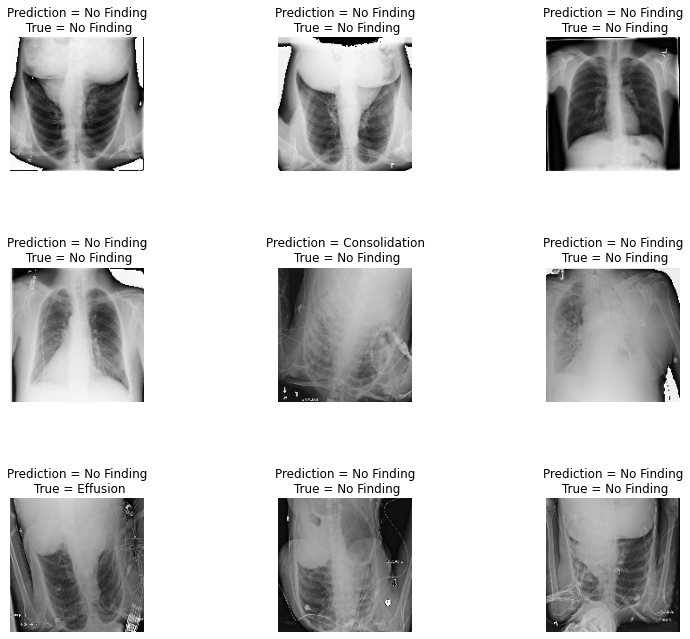

In [ ]:
## plot first few images for prediction
xray_imgdict = {
    0 : 'Atelectasis',
    1 : 'Cardiomegaly',
    2 : 'Consolidation',
    3 : 'Edema',
    4 : 'Effusion',
    5 : 'Emphysema',
    6 : 'Fibrosis',
    7 : 'Hernia',
    8 : 'Infiltration',
    9 : 'Mass',
    10 : 'No Finding',
    11 : 'Nodule',
    12 : 'Pleural_Thickening',
    13 : 'Pneumonia',
    14 : 'Pneumothorax',

}

L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (12, 12))
ax = axes.ravel()
for i in np.arange(0, L*W):
    # ax[i].imshow(X_test[i])
    ax[i].imshow((X_test[i] * 1).astype(np.uint8))
    ax[i].set_title('Prediction = {}\n True = {}'.format(xray_imgdict[predicted_classes_resnet50_test[i]], xray_imgdict[y_test_true[i]]))
    ax[i].axis('off')
plt.subplots_adjust(wspace = 1)

6


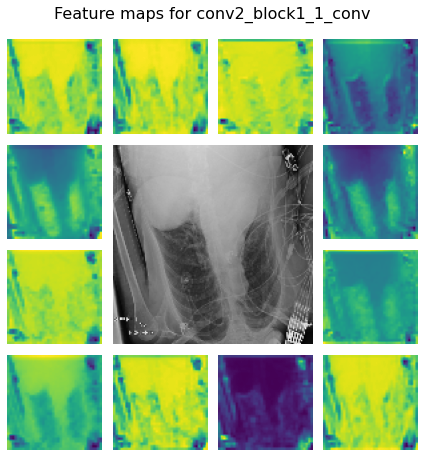

In [ ]:
## plot a random test data image (feature map)
index_resnet50 = 6 ##np.random.randint(0, 50) ## # pick a random number from 0 to 10 -- 19
print(index_resnet50)
out_idx_resnet50 = y_test[index_resnet50]
def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    # axbig.imshow(img.squeeze() + 0.5)
    axbig.imshow(img.squeeze())
    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i], cmap='viridis')
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Feature maps for {layer_names[0]}',size=16,y=1.05);

layers_list_resnet50 = renet50_model.layers
# print('\n'.join([layer.name for layer in layers_list_resnet50]))

layer_output_resnet50 = renet50_model.layers[7].output
activation_model_resnet50 = Model(inputs=renet50_model.input, outputs=layer_output_resnet50)

X_test_resnet50i = X_test[index_resnet50].reshape(1,150,150,3)
img = ((X_test_resnet50i * 1).astype(np.uint8))
activations_resnet50 = activation_model_resnet50.predict(img)
plot_featuremaps(img,activations_resnet50,[renet50_model.layers[7].name])

## 8.6 -  ResNet50: Saliency Maps and GradCAM

1015


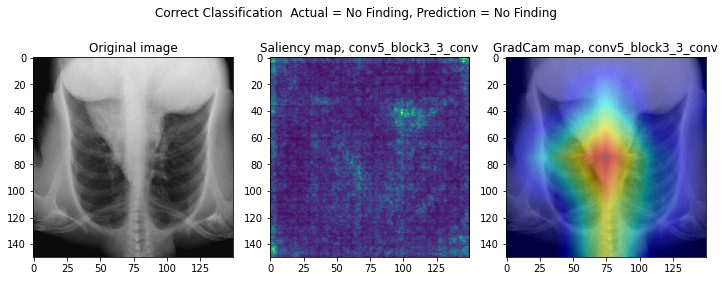

In [ ]:
# Generate saliency and Gradcam map with smoothing (for Correct classification)
index_resnet50 = 1015 ##np.random.randint(0, 10000) # pick a random number from 0 to 10000
print(index_resnet50)

X_test_resnet50i = np.expand_dims(X_test[index_resnet50], axis=0)
layr_nm = renet50_model.layers[-7].name
score_resnet50 = lambda outputs: (outputs[0][predicted_classes_resnet50_test[index_resnet50]])
saliency = Saliency(renet50_model, clone=True)
saliency_map_resnet50 = saliency(score_resnet50, X_test_resnet50i, smooth_samples=20, smooth_noise=0.20)

# Generate heatmap with GradCAM
gradcam = Gradcam(renet50_model, clone=True)
cam_resnet50 = gradcam(score_resnet50, X_test[index_resnet50], penultimate_layer=-7)
heatmap = np.uint8(cm.jet(cam_resnet50[0])[..., :3] * 255)

# plot and render the images
fig, ax = plt.subplots(1,3, figsize=(10, 4))
input_image_resnet50 = ((X_test[index_resnet50] * 1).astype(np.uint8))
ax[0].imshow(input_image_resnet50)
fig.suptitle('Correct Classification  Actual = {}, Prediction = {}'.format(xray_imgdict[y_test_true[index_resnet50]], xray_imgdict[predicted_classes_resnet50_test[index_resnet50]]), fontsize=12)
ax[0].set_title('Original image')
ax[1].imshow(saliency_map_resnet50[0], cmap='viridis')
ax[1].set_title(f'Saliency map, {layr_nm}')
ax[2].imshow(input_image_resnet50.sum(axis=2), cmap='gray')
ax[2].imshow(heatmap, cmap='viridis', alpha = 0.5)
ax[2].set_title(f'GradCam map, {layr_nm}')
plt.tight_layout()
plt.show() 

45


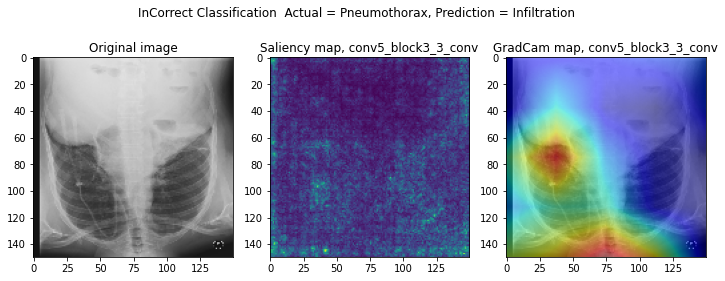

In [ ]:
# Generate saliency and Gradcam map with smoothing (for Incorrect classification)
index_resnet50 = 45 ##np.random.randint(0, 10000) # pick a random number from 0 to 10000 - 1025
print(index_resnet50)

X_test_resnet50i = np.expand_dims(X_test[index_resnet50], axis=0)
layr_nm = renet50_model.layers[-7].name
score_resnet50 = lambda outputs: (outputs[0][predicted_classes_resnet50_test[index_resnet50]])
saliency = Saliency(renet50_model, clone=True)
saliency_map_resnet50 = saliency(score_resnet50, X_test_resnet50i, smooth_samples=20, smooth_noise=0.20)

# Generate heatmap with GradCAM
gradcam = Gradcam(renet50_model, clone=True)
cam_resnet50 = gradcam(score_resnet50, X_test[index_resnet50], penultimate_layer=-7)
heatmap = np.uint8(cm.jet(cam_resnet50[0])[..., :3] * 255)

# plot and render the images
fig, ax = plt.subplots(1,3, figsize=(10, 4))
input_image_resnet50 = ((X_test[index_resnet50] * 1).astype(np.uint8))
ax[0].imshow(input_image_resnet50)
fig.suptitle('InCorrect Classification  Actual = {}, Prediction = {}'.format(xray_imgdict[y_test_true[index_resnet50]], xray_imgdict[predicted_classes_resnet50_test[index_resnet50]]), fontsize=12)
ax[0].set_title('Original image')
ax[1].imshow(saliency_map_resnet50[0], cmap='viridis')
ax[1].set_title(f'Saliency map, {layr_nm}')
ax[2].imshow(input_image_resnet50.sum(axis=2), cmap='gray')
ax[2].imshow(heatmap, cmap='viridis', alpha = 0.5)
ax[2].set_title(f'GradCam map, {layr_nm}')
plt.tight_layout()
plt.show() 

## **8.7 - ResNet50: Discussion of Results**

As we can see from the plotting of the model training history and the resulting performance metrics on the test set, the ResNet50 model shows exhibits quite different metrics than Baseline CCN and VGG19 models, with training accuracy of 84.0%, validation accuracy of 59.3%, and test accuracy of 56.2%.

This suggests that the model is heavily overfitting to features that are not distinct to their particular disease labels. Specifically, the training accuracy shows that the model can accurately predict disease labels at rates much higher than the previous two models, but the model doesn't generalize well because it is learning features within these images that are not universal across the disease labels.

This could be for several reasons, one of which is the accuracy of the disease labels, and the other of which is the fact that we have created mutually exclusive training, validation, and test sets, based on the unique patient IDs. In the original paper by Wang et al. in 2017, they do not mention whether their training, validation, and test sets are designed with cross-validation leakage in mind (i.e with mutually exclusive use of patient IDs between datasets).

We believe that the extra layers within this model are learning features that are distinct to particular images, but it does not seem they are learning features that are distinct to particular disease labels, which should be evident if it is able to generalize across data sets.

---
# **9. Downsampling of Training data**

Given the significant class imbalance in the dataset, we attempt downsampling using the ResNet50 model to see if we can increase our model's learning of the minority classes instead of overfitting mainly to the majority class.

In this downsampled dataset, we reduce the majority class to 10% of the original dataset, while maintaining all other minority classes (originally, the majority class represented ~66% of the dataset). We reduce the majority class by random sampling without replacement.

As can be seen with the training results below, downsampling the training dataset does not allow the model to further learn the features of the other disease labels. Our trianing accuracy decreases to ~20%, which is the rough percentage of the "No Finding" labels, which suggests that the model is once again over fitting to this particular label.

In [ ]:
X_train_down = np.load('/content/drive/Shareddrives/cs109b Project/downsample_data/X_train_down.npy', allow_pickle=True)
y_train_down = np.load('/content/drive/Shareddrives/cs109b Project/downsample_data/y_train_down.npy', allow_pickle=True)
print(X_train_down.shape)
print(y_train_down.shape)

(19386, 150, 150, 3)
(19386, 15)


In [ ]:
renet50_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=1e-5, verbose=1)

history_resnet50_down = renet50_model.fit(X_train_down, y_train_down,
                    validation_data = valid_data_batches, 
                    epochs=5,
                    callbacks = [reduce_lr],
                    verbose=1)

Epoch 1/5
606/606 [==============================] - 474s 774ms/step - loss: 6.0775 - acc: 0.5909 - val_loss: 22.6172 - val_acc: 0.1635 - lr: 0.0010
Epoch 2/5
606/606 [==============================] - 459s 758ms/step - loss: 5.5040 - acc: 0.6252 - val_loss: 19.0150 - val_acc: 0.1968 - lr: 0.0010
Epoch 3/5
606/606 [==============================] - 456s 753ms/step - loss: 5.0899 - acc: 0.6509 - val_loss: 14.1941 - val_acc: 0.3883 - lr: 0.0010
Epoch 4/5
606/606 [==============================] - 460s 760ms/step - loss: 4.7058 - acc: 0.6719 - val_loss: 19.4822 - val_acc: 0.2471 - lr: 0.0010
Epoch 5/5
606/606 [==============================] - 410s 677ms/step - loss: 4.4843 - acc: 0.6914 - val_loss: 22.7265 - val_acc: 0.2284 - lr: 0.0010


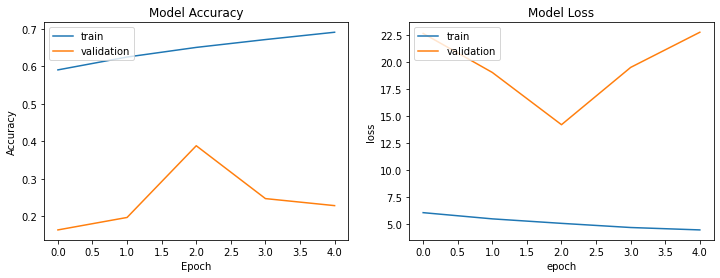

In [ ]:
## Plot training and validation loss and accuracy
def plot_loss(model_history, out_file = None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    
    ax[0].plot(history_resnet50_down.history['acc'])
    ax[0].plot(history_resnet50_down.history['val_acc'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history_resnet50_down.history['loss'])
    ax[1].plot(history_resnet50_down.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')


    plt.show()
    
    if out_file:
        plt.savefig(out_file)

plot_loss(model_history = history_resnet50_down);

# **10. Upsampling of Training data**

We also attempt upsampling with the ResNet50 model. With upsampling, we won't be losing any data, as the majority class is not reduced. With this upsampled dataset, we increase the miniority classes to twice their original number of images using random sampling with replacement.

As can be seen in the below training results, our model once again seems to be over fitting to the "no finding labels", as the training accuracy follows the percentage of "no finding labels" in the dataset, suggesting that random upsampling of the minority images does not help the model learn more distinct features of disease labels.

In [ ]:
X_train_up = np.load('/content/drive/Shareddrives/cs109b Project/upsample_data/X_train_up.npy', allow_pickle=True)
y_train_up = np.load('/content/drive/Shareddrives/cs109b Project/upsample_data/y_train_up.npy', allow_pickle=True)
print(X_train_up.shape)
print(y_train_up.shape)

(60588, 150, 150, 3)
(60588, 15)


In [ ]:
renet50_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              metrics=['acc'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=1e-5, verbose=1)

history_resnet50_up = renet50_model.fit(X_train_up, y_train_up,
                    validation_data = valid_data_batches,
                    steps_per_epoch= 100,
                    validation_steps=100,
                    batch_size = 128,
                    epochs=5,
                    callbacks = [reduce_lr],
                    verbose=1)
                      

Epoch 1/5
100/100 [==============================] - 134s 1s/step - loss: 7.6664 - acc: 0.3559 - val_loss: 3.5177 - val_acc: 0.3831 - lr: 0.0010
Epoch 2/5
100/100 [==============================] - 144s 1s/step - loss: 4.7954 - acc: 0.3780 - val_loss: 3.5159 - val_acc: 0.4375 - lr: 0.0010
Epoch 3/5
100/100 [==============================] - 142s 1s/step - loss: 5.0954 - acc: 0.3869 - val_loss: 3.9329 - val_acc: 0.5469 - lr: 0.0010
Epoch 4/5
100/100 [==============================] - 142s 1s/step - loss: 5.4153 - acc: 0.3802 - val_loss: 4.3490 - val_acc: 0.5031 - lr: 0.0010
Epoch 5/5
100/100 [==============================] - ETA: 0s - loss: 5.1465 - acc: 0.4106
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
100/100 [==============================] - 143s 1s/step - loss: 5.1465 - acc: 0.4106 - val_loss: 5.4760 - val_acc: 0.3787 - lr: 0.0010


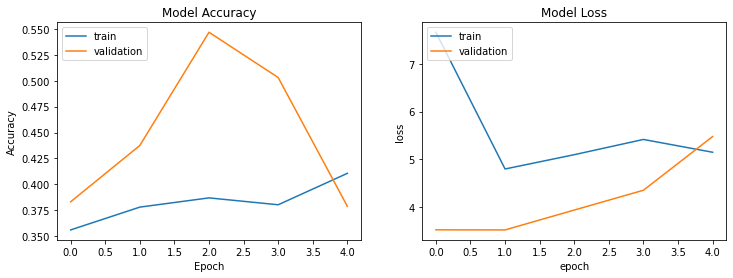

In [ ]:
## Plot training and validation loss and accuracy
def plot_loss(model_history, out_file = None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    
    ax[0].plot(history_resnet50_up.history['acc'])
    ax[0].plot(history_resnet50_up.history['val_acc'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history_resnet50_up.history['loss'])
    ax[1].plot(history_resnet50_up.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')


    plt.show()
    
    if out_file:
        plt.savefig(out_file)

plot_loss(model_history = history_resnet50_up);

# **11. Model Performance Comparisons**
In this section we compare the various models that we have chosen to train on, and their performance on both the train and test sets.

Given we have an imbalanced dataset, we choose to include f1 score alongside other traditional metrics, such as accuracy, precision, and recall. The F1 score for a certain class is the harmonic mean of its precision and recall, so it’s an overall measure of the quality of a classifier’s predictions. It is one of the metris of choice as it captures both precision and recall.

Alternate way of obtaining a single performance indicator is by averaging the precision and recall scores of individual classes. This gives global precision and recall scores that we can then use to compute a global F1 score. In our models, we used weighted average for comparison of performance.

We discuss comparisons between models below.


In [ ]:
# Helper function to report the scores for a model
def report_model_results(model, model_name, y_train_true, y_train_preds, y_test_true, y_test_preds): 
    
    scores = {
        'model': model_name,
        'f1score': f1_score(y_test_true, y_test_preds, average = 'weighted'),
        'Precision': precision_score(y_test_true, y_test_preds, average = 'weighted'),
        'Recall': recall_score(y_test_true, y_test_preds, average = 'weighted'),
        'Training Accuracy': accuracy_score(y_train_true, y_train_preds),
        'Test Accuracy': accuracy_score(y_test_true, y_test_preds)
    }
    print(f'{model_name}')
    print(f"*f1 Score: {scores['f1score']:.4f}")
    print(f"*Precision: {scores['Precision']:.4f}")
    print(f"*Recall: {scores['Recall']:.4f}")
    print(f"*Training Accuracy: {scores['Training Accuracy']:.4f}")
    print(f"*Test Accuracy: {scores['Test Accuracy']:.4f}")
    
    return scores

In [ ]:
cnn_model_scores = report_model_results(cnn_model, 'cnn_model', y_train_true, predicted_classes_cnn_train, y_test_true, predicted_classes_cnn_test)
cnn_scores_df = pd.DataFrame(cnn_model_scores.items() , columns = ['modelparam', 'modelval'])
cnn_scores_n = cnn_scores_df.T.set_index([0])


cnn_model
*f1 Score: 0.4940
*Precision: 0.4224
*Recall: 0.6319
*Training Accuracy: 0.6734
*Test Accuracy: 0.6319


In [ ]:
vgg_model_scores = report_model_results(vgg_model, 'VGG19_model', y_train_true, predicted_classes_vgg_train, y_test_true, predicted_classes_vgg_test)
vgg_scores_df = pd.DataFrame(vgg_model_scores.items() , columns = ['modelparam', 'modelval'])
vgg_scores_n = vgg_scores_df.T.set_index([0])[1:]

VGG19_model
*f1 Score: 0.4971
*Precision: 0.4301
*Recall: 0.6291
*Training Accuracy: 0.6700
*Test Accuracy: 0.6291


In [ ]:
resnet50_model_scores = report_model_results(renet50_model, 'ResNet50_model', y_train_true, predicted_classes_resnet50_train, y_test_true, predicted_classes_resnet50_test)
resnet50_scores_df = pd.DataFrame(resnet50_model_scores.items() , columns = ['modelparam', 'modelval'])
resnet50_scores_n = resnet50_scores_df.T.set_index([0])[1:]

ResNet50_model
*f1 Score: 0.4966
*Precision: 0.4602
*Recall: 0.5617
*Training Accuracy: 0.8401
*Test Accuracy: 0.5617


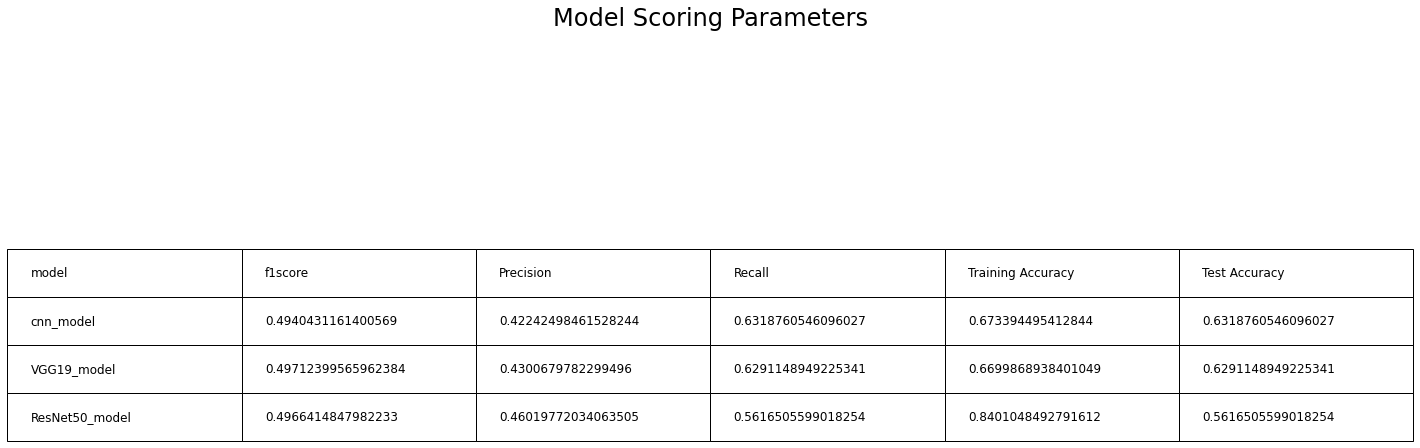

In [ ]:
final_models_df = pd.concat([cnn_scores_n, vgg_scores_n, resnet50_scores_n])
final_models_df.columns = final_models_df.iloc[0]
final_model_scores_out = final_models_df[1:].rename_axis(None)
final_model_scores_output = final_model_scores_out.rename_axis('model').reset_index()
fig, ax = plt.subplots()
ax.set_title('Model Scoring Parameters', fontsize=24)
ax.axis('off')
ax.axis('tight')
tt_34= ax.table(cellText=final_model_scores_output.values, colWidths = [0.7]*len(final_model_scores_output.columns), colLabels=final_model_scores_output.columns, cellLoc='left', colLoc = 'left')
tt_34.auto_set_font_size(False) 
tt_34.set_fontsize(12)
tt_34.scale(1, 4)
plt.show()

## **11.1 - Discussion of Model Performance Metrics**

We can see from the above score comparison output that our original baseline model was able to generalize to the test dataset. However, the baseline CNN model was mostly able to learn features unique to the "No Finding" label. However, our ResNet50 model showed the the highest training accuracy, suggesting that it was able to learn features that were distinct to the images of the minority classes. However, unfortunately, its inability to generalize well to the test data seems to suggest that the features learned by the  ResNet model were actually just structured noise.

Overall, it seems that reduction of image size to 150x150 in order to train the models seems to have muddled the distinct disease features quite a bit. We discuss this and other reasons in the conclusion section below.



## **11.2 - Plotting AUROC Curves**

Receiver Operating Characteristic (ROC) metric is to evaluate classifier output quality.

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate. In order to extend ROC curve and ROC area to multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging). Another evaluation measure for multi-label classification is macro-averaging, which gives equal weight to the classification of each label.

We have binarized the output and plotted the ROC curve for multi label classification

In [ ]:
## ROC CURVE for models

target= ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 
'Fibrosis', 'Hernia','Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 
'Pneumonia', 'Pneumothorax']

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_true, predicted_classes, average="macro"):
    y_test = y_true
    y_pred = predicted_classes
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.6f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


ROC AUC score: 0.5000279372884403


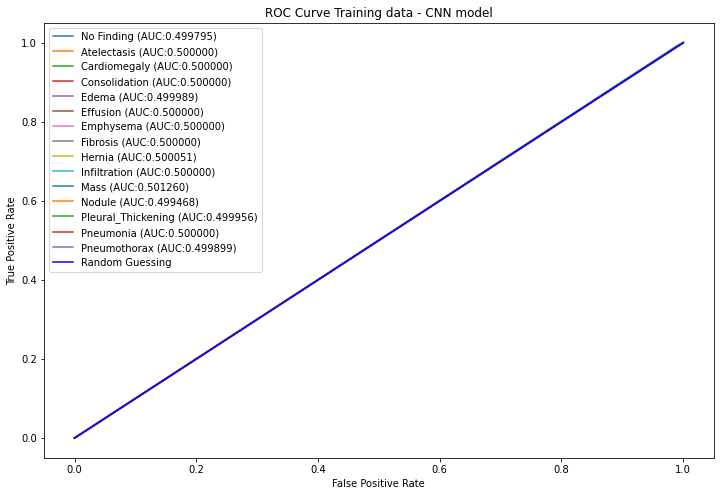

In [ ]:
## # multiclass_roc_auc_score for cnn model training data
# set plot figure size
fig, (c_ax) = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(y_train_true, predicted_classes_cnn_train))
c_ax.legend()
c_ax.set_title('ROC Curve Training data - CNN model')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.4999147184202587


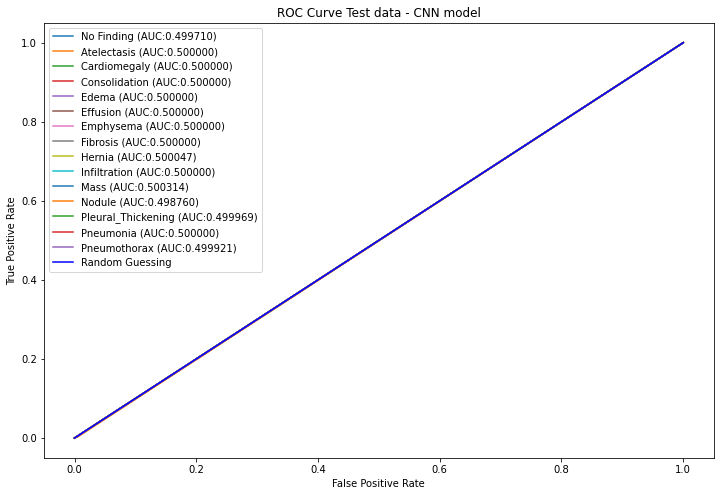

In [ ]:
## # multiclass_roc_auc_score for cnn model test data
# set plot figure size
fig, (c_ax) = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(y_test_true, predicted_classes_cnn_test))
c_ax.legend()
c_ax.set_title('ROC Curve Test data - CNN model')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score VGG19: 0.5007782605941272


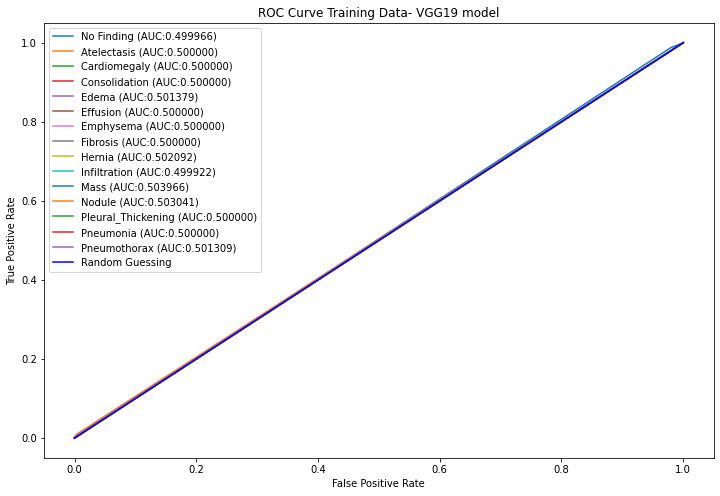

In [ ]:
# multiclass_roc_auc_score for VGG19 training data
fig, (c_ax) = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score VGG19:', multiclass_roc_auc_score(y_train_true, predicted_classes_vgg_train))
c_ax.legend()
c_ax.set_title('ROC Curve Training Data- VGG19 model')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score VGG19: 0.5006160110087134


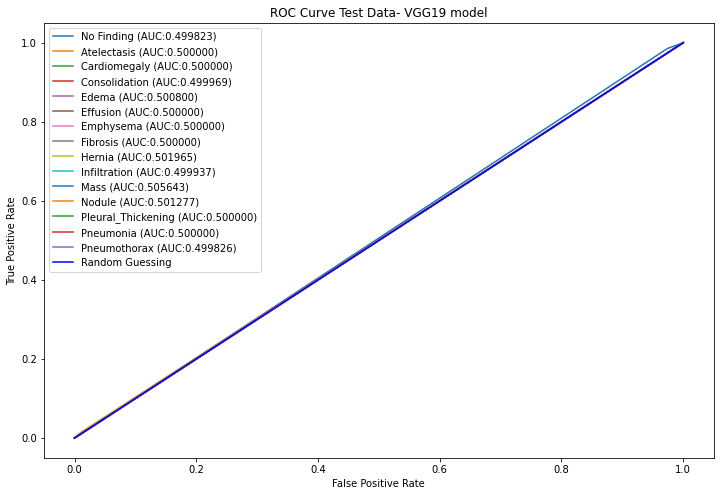

In [ ]:
# multiclass_roc_auc_score for VGG19 TEST data
fig, (c_ax) = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score VGG19:', multiclass_roc_auc_score(y_test_true, predicted_classes_vgg_test))
c_ax.legend()
c_ax.set_title('ROC Curve Test Data- VGG19 model')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score resnet50: 0.8716027273762438


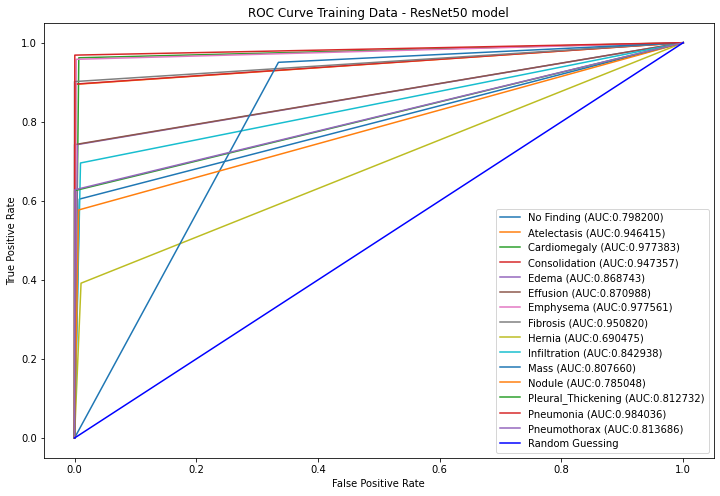

In [ ]:
# multiclass_roc_auc_score for resnet50 training data
fig, (c_ax) = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score resnet50:', multiclass_roc_auc_score(y_train_true, predicted_classes_resnet50_train))
c_ax.legend()
c_ax.set_title('ROC Curve Training Data - ResNet50 model')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score resnet50: 0.5132834637363891


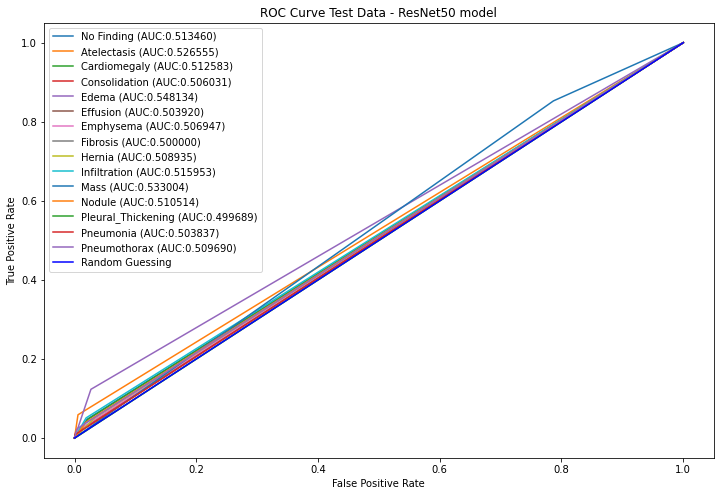

In [ ]:
# multiclass_roc_auc_score for resnet50
fig, (c_ax) = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score resnet50:', multiclass_roc_auc_score(y_test_true, predicted_classes_resnet50_test))
c_ax.legend()
c_ax.set_title('ROC Curve Test Data - ResNet50 model')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## **11.3 - Discussion of AUROC Curves**

The AUROC curves from our Baseline CNN and VGG19 models unfortunately do not pass the random guessing lines of the AUROC curve, however our ResNet model was able to exhibit high AUROC on the training set, and a slightly better AUROC score compared to Baseline CNN and VGG19 models on the test set. Despite the ResNet50 model's lower overall accuracy on the test data set, it was able to exhibit slightly above random guessing line for several disease labels suggesting that it was learning something distinct to those images. Further discussion of results in the conclusion below. 

---

# **12. Conclusions and Further Steps**

Based on the above score comparisons and AUROC scores, our models have room for improvement. We believe our models may not have trained very well due to our need for more computational resources, the low resolution of images (given our resizing), and the significant class imabalance present in the dataset.

Given the large size of the dataset in terms of memory and the current computational resources available to us, it was incredibly difficult to realistically train the model and perform significant iterations on a large array of model hyperparameters. Models would often crash, and RAM would often be overloaded before models could finish training.

Given this, we opted to resize the image from 1024x1024  to 150x150, which is a 97.9% reduction in pixels. With lower resolution, there may not have been as many distinct features from the various thoracic diseases for our models to learn.

This is exacerbated by the fact that the original dataset was significantly imbalanced with 66% of the dataset represented by "no finding" labels, and 8 out of 14 disease labels representing less than 1% of the dataset respectively.

In the original research paper, Wang et al. had 4 GPUs available to them to  train for unspecified period of time, on 8 disease labels. In the future, if we are given additional computing resources and time, we would re-attempt training on the full size of the images to see if distinct features can be captured. It is also unclear whether images with "No Finding" labels were included in their training, as they did not include "No Finding" scores in their test results.

Additionally, we also would like to bring to note that there have been objections made to the validity of the disease labels themselves. In the original paper, Wang et al. claim there is 90% or greater label accuracy, and maintain this claim in the updated ChestXray-14 dataset. However, an independent audit of the labels from radiologist Lauren Oakden-Rayner seem to suggest that label accuracy might be in a range from 24-80%, with several categories at ~30%. Moreover, Oakden-Rayner questions the use of chest x-rays for several of the disease labels such as effusion and fibrosis, and that often these diseases are diagnosed using other clinical methods and information. This would suggest that there are no distinct disease features in those x-rays to begin with even if the labels are correct, and that training a model on such images would ultimately result in learning structured noise.

However, overall, we do believe that deep learning using x-ray imaging has a future in medical diagnosis. Given the above considerations and with more time and additional resources, our team would re-attempt training with more model tuning, while training on full image sizes, and auditing the disease labels with the original research team in order to ensure they are both accurate and relevant.

---

# **13. References**

[1] X. Wang, Y. Peng, L. Lu, Z. Lu, M. Bagheri, and R. Summers. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. In CVPR, 2017. https://arxiv.org/abs/1705.02315.

[2] P. Rajpurkar, J. Irvin, R. L. Ball, K. Zhu, B. Yang, H. Mehta, et al. (2018) Deep learning for chest radiograph diagnosis: A retrospective comparison of the CheXNeXt algorithm to practicing radiologists. PLoS Med 15(11): e1002686. https://doi.org/10.1371/journal.pmed.1002686.

[3] P. Rajpurkar, B. Uyumazturk, A. Kiani, and E. Shyu. Coursera: AI for Medical Diagnosis, AI for Medicine Specialization: www.coursera.org/learn/ai-for-medical-diagnosis?specialization=ai-for-medicine.

[4] ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases (https://arxiv.org/abs/1705.02315)

[5] ResNet-50 vs VGG-19 vs training from scratch: A comparative analysis of the segmentation and classification of Pneumonia from chest X-ray images (https://www.sciencedirect.com/science/article/pii/S2666285X21000558)

[6] https://hamdi-ghorbel78.medium.com/a-guide-to-transfer-learning-with-keras-using-resnet50-453934a7b7dc

[7] https://laurenoakdenrayner.com/2017/12/18/the-chestxray14-dataset-problems/
